# TARGET project, week 4

Welcome to the final week of our project, let's wrap up!

## Technical paper on the quadrupole system

The quad system we have been examining, is basically the same as used in a previous experiment in Brookhaven National Lab. They wrote a 27-page paper on the system, that is still the best available resource:  


https://www.g-2.bnl.gov/publications/QUAD_NIMA_paper_030511.pdf

The paper is very technical, it covers everything from the hardware design, to the generated field, to the effects on particles traveling in the field.  
But you can find a wealth of information there. For example, here is a drawing of the motion of a particle inside the field of the magnet and the quads. I described it before in discussion, here's what it looks like in a scientific paper.


<img src="https://github.com/ManolisKar/TARGET_2021_project/blob/main/images/particle_motion.png?raw=true" />

It's probably interesting for you to see what a scientific paper looks like. Feel free to flip through the pages to get an idea of all the complexity -- but you don't have to read 27 pages!  

Most relevant for us is section 6, where the field of the plates is discussed.

## Function and parameters that describe the field


As we discussed last week, our ultimate goal is to find the parameters that describe the poential everywhere inside the plates.  

The function that describes the potential is given in equation (19) of the paper:

<img src="https://github.com/ManolisKar/TARGET_2021_project/blob/main/images/potential_equation.png?raw=true" />

* Here U is the potential.  
* Notice that "r" and "θ" have different definitions than we used previously. Now the (x,y)=(0,0) point is placed in the center of the storage region. Then x=r\*cosθ and y=r\*sinθ are the coordinates on an azimuthal slice.  
* Our parameters a0, b0, a1, b1, a2, b2, ..., a1000, b1000, ...

It is an infinite sum -- that means infinite parameters!  Reality is complex indeed!

However, we don't really need all the infinite parameters. We can go up to n=5,10,20, ... . At some point we will have enough terms to describe the field "close enough".  But we need to have enough to describe some important realities in the data. 

###  <font color='red'>  Question: </font>  

Which of the a_n, b_n terms is the biggest and most important? Eg, for which value of n?  

Hint: Think of the shape of the potential. Which value of n describes most of it? That order of n will be much more important than all others.

## Fitting the data to the function

In [ ]:
import numpy as np
import scipy.optimize
#from math_functions import *
import matplotlib.pyplot as plt
import sys

First lets read in all data.

In [ ]:
try:
    import urllib.request as urllib2
except ImportError:
    import urllib2
bottomquad_url = 'https://raw.githubusercontent.com/ManolisKar/TARGET_2021_project/main/quad_field.dat'
datafile = urllib2.urlopen(bottomquad_url)

file_content = datafile.read().decode('utf-8')
print(file_content)
datafile.close()

In [ ]:
x, y, z, r, th, V, Ex, Ey, Ez, Er, Et = [], [], [], [],[],[],[],[],[],[],[]
i=0
for line in file_content.splitlines():

    #if line[0]=='!': continue
    try:
        #print (i, line)
        x_t, y_t, z_t, r_t, th_t, V_t, Ex_t, Ey_t, Ez_t, Er_t, Et_t = line.split()
        x.append(float(x_t))
        y.append(float(y_t))
        r.append(float(r_t))
        th.append(float(th_t))
        z.append(float(z_t))
        V.append(float(V_t))
        Ex.append(float(Ex_t))
        Ey.append(float(Ey_t))
        Er.append(float(Er_t))
        Et.append(float(Et_t))
        Ez.append(float(Ez_t))
        print (x_t,th_t,z_t)
        i+=1
    except ValueError:
        continue

x=np.array(x)
y=np.array(y)
z=np.array(z)

r=np.array(r)
th=np.array(th)
V=np.array(V)
Er=np.array(Er)
Et=np.array(Et)
Ez=np.array(Ez)



Some terms:  

* "residual": The difference between the measured truth and the function prediction at a point.  
* "chi2" (read chi-squared): The squared sum of all residuals. We want to make the residuals as small as possible, then our function will match reality. So our goal is to minimize chi2.

In [ ]:
## Global parameters
## The best chi2 solution we have found so far
best_chi2 = 1e10 ## we initialize it to a very large number, so it can only be reduced from here

## The best parameters we have found that give the best solution
best_pars = np.zeros(100)

## We will iterate the calculations many times before we find a good solution. We should count the number of iterations.
iter_count=0


Now, here is the function that models the potential. It is the same as equation (19).  
We give the function some parameters (which are the a_n, b_n parameters) and the function tells us what's the potential at some coordinates.  

We can choose to what order in n we want to go in the sum. But make sure the dimensions of the passed parameters matches that order. 

In [112]:
def model_potential(parameters, coordinates, n_order):
    # Model function for the potential at a point with *polar* coordinates (r,theta), with origin at the center of the storage region.
    # pars is an array of the a,b parameters up to order n_order
    r_coord = np.array(coordinates[:,0])
    th_coord = np.array(coordinates[:,1])

    model_V = np.zeros(len(r_coord)) # each element is a multipole sum over n orders
    for i in range(len(model_V)): 
        for n in range(n_order+1):
            an=parameters[2*n]
            bn=parameters[2*n+1]
            model_V[i] += np.power(r_coord[i],n) *(an*np.sin(n*th_coord[i]) + bn*np.cos(n*th_coord[i]))
    return model_V 


And here is a function that gives the residuals:  
How far away from the truth the function's predictions are, givn the values of some parameteres up to some order. 

In [113]:

def residual(iter_pars, coordinates, V, err_V, n_order):
    global iter_count
    global best_chi2
    global best_pars
    #global found_better_solution
    
    model_V = model_potential(iter_pars, coordinates, n_order)
    norm_residuals = (V - model_V)/err_V
    sum_residuals = sum(np.power(norm_residuals,2.))

    ndf = len(model_V) - len(iter_pars)
    reduced_chi2 = sum_residuals/ndf
    if reduced_chi2<best_chi2:
        best_chi2=reduced_chi2
        best_pars=iter_pars
        #found_better_solution=1

    if iter_count%100==0:
        print ('\n\nIteration #', iter_count)
        #if found_better_solution:
        
        ## we print the parameters of the best solution in a useful format
        print ('Best solution::\n[')
        for parameter in best_pars:
            print (parameter, ',')
        print(']')
        print ('\nnmax   reduced-chi2    max-residual::')
        print (n_order, best_chi2, max(norm_residuals))
        #print ('Time elapsed :: %.2f'% (time.time()-start))
        sys.stdout.flush()
        #found_better_solution=0

    iter_count += 1
    return norm_residuals

Notice that this function periodically prints out the best found parameters and the corresponding chi2.

In [114]:
# Construct polar coordinates with origin at center of storage region
x = np.array(r-711.2) # in cm
th_polar = np.array(np.arctan2(z,x))
r_polar = np.array(x/np.cos(th_polar))



(array([ 158.,  406.,  648.,  894., 1136., 1386., 1620., 1590.,  830.,
         354.]),
 array([0.10107784, 0.69226789, 1.28345794, 1.874648  , 2.46583805,
        3.0570281 , 3.64821815, 4.2394082 , 4.83059826, 5.42178831,
        6.01297836]),
 <BarContainer object of 10 artists>)

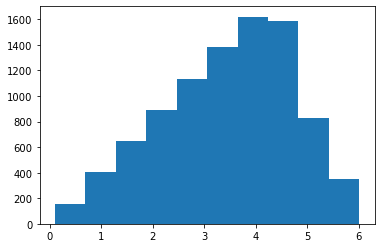

In [125]:
plt.hist(r_polar)

In [172]:
cut = (np.abs(th-6.5)<0.03) & ( (np.abs(r_polar-4.5)<0.08) | (np.abs(r_polar-4.0)<0.08)| (np.abs(r_polar-3.5)<0.08) )

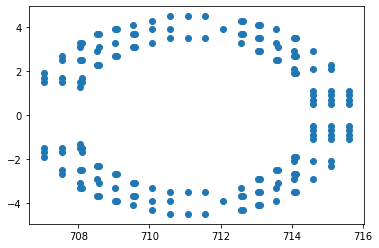

In [173]:
plt.scatter(r[cut],z[cut])

In [174]:
## just packaging the coordinates here
coordinates = np.vstack((r_polar[cut],th_polar[cut])).T

In [168]:
len(coordinates)

114

In [132]:
err_V=1

In [133]:
n_order=22

In [122]:
# pars is 1-D array of parameters to be optimized.
# pars[2*n] are the A_n, pars[2*n+1] are the B_n.
# Note that this definition picks up the correct dimensions for any n_order.
starting_parameters = np.zeros(2*(n_order+1))


In [150]:
## we know something about the system -- that it's dominated by the quadrupole b2 term.
## lets pass that knowledge by limiting parameter values
low_limit = np.zeros(2*(n_order+1))
hi_limit = np.zeros(2*(n_order+1))
for i in range(2*n_order+2):
    low_limit[i]=-np.inf
    hi_limit[i]=np.inf

low_limit[0]=-1e4
hi_limit[0]=1e4
low_limit[1]=-1e4
hi_limit[1]=1e4
low_limit[2]=-2e3
hi_limit[2]=2e3
low_limit[3]=-2e3
hi_limit[3]=2e3
low_limit[4]=-5e2
hi_limit[4]=5e2
low_limit[5]=-1e20
hi_limit[5]=1
low_limit[6]=-2e2
hi_limit[6]=2e2
low_limit[7]=-2e2
hi_limit[7]=2e2
low_limit[8]=-5e1
hi_limit[8]=5e1
low_limit[9]=-5e1
hi_limit[9]=5e1

for par_id in range(9,len(low_limit)):
    low_limit[par_id]=-1
    hi_limit[par_id]=1

par_bounds = (low_limit, hi_limit)


par_bounds


(array([-1.e+04, -1.e+04, -2.e+03, -2.e+03, -5.e+02, -1.e+20, -2.e+02,
        -2.e+02, -5.e+01, -1.e+00, -1.e+00, -1.e+00, -1.e+00, -1.e+00,
        -1.e+00, -1.e+00, -1.e+00, -1.e+00, -1.e+00, -1.e+00, -1.e+00,
        -1.e+00, -1.e+00, -1.e+00, -1.e+00, -1.e+00, -1.e+00, -1.e+00,
        -1.e+00, -1.e+00, -1.e+00, -1.e+00, -1.e+00, -1.e+00, -1.e+00,
        -1.e+00, -1.e+00, -1.e+00, -1.e+00, -1.e+00, -1.e+00, -1.e+00,
        -1.e+00, -1.e+00, -1.e+00, -1.e+00]),
 array([1.e+04, 1.e+04, 2.e+03, 2.e+03, 5.e+02, 1.e+00, 2.e+02, 2.e+02,
        5.e+01, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00,
        1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00,
        1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00,
        1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00,
        1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00]))

In [175]:
iter_count=-1
residual(starting_parameters,coordinates,V[cut],err_V,n_order)
fit_result = scipy.optimize.least_squares(residual, starting_parameters, method='trf',max_nfev=1e12,args=(coordinates, V[cut], err_V, n_order),ftol=3e-16,xtol=3e-16, bounds=par_bounds )

print ('\n\n Number of iterations:: %d / %d\n' % (iter_count, fit_result.nfev))
print ('Result status = ', fit_result.status)
print ('Cost = ', fit_result.cost)
print ('Optimality = ', fit_result.optimality)
print ('Fit parameters ::\n', fit_result.x)



Iteration # 0
Best solution::
[
746.160617513546 ,
384.7783828009344 ,
-247.51654097348322 ,
-111.03359922423672 ,
-2.1636019732330967 ,
-764.7482816738512 ,
3.758924060146975 ,
-3.0586682700889334 ,
-0.167325489176437 ,
-0.25453512537371037 ,
0.06469748168017664 ,
-0.09987002665440543 ,
-0.01059850793217094 ,
0.073170638928071 ,
0.0006337267931631128 ,
-0.004222425733504324 ,
-0.0005705665069365855 ,
0.001340569596373809 ,
0.00020620224496918773 ,
-0.0001927892353638128 ,
-2.79980179215292e-05 ,
8.527208879163808e-05 ,
6.011987255099313e-06 ,
-8.08670068594849e-06 ,
-1.3865018456509272e-06 ,
1.6894985352303662e-06 ,
2.402311951658138e-07 ,
-3.3957188370006486e-07 ,
-5.618724189973732e-08 ,
5.040271287130266e-08 ,
1.2923459966499192e-08 ,
-1.3477962785679396e-08 ,
-2.1304624671918808e-09 ,
2.1233319514365167e-09 ,
3.82490702131776e-10 ,
-4.900405936210406e-10 ,
-6.734208336044164e-11 ,
5.886111093976625e-11 ,
1.6426781230151187e-11 ,
-1.659653986385823e-11 ,
-2.446570098914207e-12 ,




Iteration # 700
Best solution::
[
746.160617513546 ,
384.7783828009344 ,
-247.51654097348322 ,
-111.03359922423672 ,
-2.1636019732330967 ,
-764.7482816738512 ,
3.758924060146975 ,
-3.0586682700889334 ,
-0.167325489176437 ,
-0.25453512537371037 ,
0.06469748168017664 ,
-0.09987002665440543 ,
-0.01059850793217094 ,
0.073170638928071 ,
0.0006337267931631128 ,
-0.004222425733504324 ,
-0.0005705665069365855 ,
0.001340569596373809 ,
0.00020620224496918773 ,
-0.0001927892353638128 ,
-2.79980179215292e-05 ,
8.527208879163808e-05 ,
6.011987255099313e-06 ,
-8.08670068594849e-06 ,
-1.3865018456509272e-06 ,
1.6894985352303662e-06 ,
2.402311951658138e-07 ,
-3.3957188370006486e-07 ,
-5.618724189973732e-08 ,
5.040271287130266e-08 ,
1.2923459966499192e-08 ,
-1.3477962785679396e-08 ,
-2.1304624671918808e-09 ,
2.1233319514365167e-09 ,
3.82490702131776e-10 ,
-4.900405936210406e-10 ,
-6.734208336044164e-11 ,
5.886111093976625e-11 ,
1.6426781230151187e-11 ,
-1.659653986385823e-11 ,
-2.446570098914207e-12 



Iteration # 1400
Best solution::
[
746.160617513546 ,
384.7783828009344 ,
-247.51654097348322 ,
-111.03359922423672 ,
-2.1636019732330967 ,
-764.7482816738512 ,
3.758924060146975 ,
-3.0586682700889334 ,
-0.167325489176437 ,
-0.25453512537371037 ,
0.06469748168017664 ,
-0.09987002665440543 ,
-0.01059850793217094 ,
0.073170638928071 ,
0.0006337267931631128 ,
-0.004222425733504324 ,
-0.0005705665069365855 ,
0.001340569596373809 ,
0.00020620224496918773 ,
-0.0001927892353638128 ,
-2.79980179215292e-05 ,
8.527208879163808e-05 ,
6.011987255099313e-06 ,
-8.08670068594849e-06 ,
-1.3865018456509272e-06 ,
1.6894985352303662e-06 ,
2.402311951658138e-07 ,
-3.3957188370006486e-07 ,
-5.618724189973732e-08 ,
5.040271287130266e-08 ,
1.2923459966499192e-08 ,
-1.3477962785679396e-08 ,
-2.1304624671918808e-09 ,
2.1233319514365167e-09 ,
3.82490702131776e-10 ,
-4.900405936210406e-10 ,
-6.734208336044164e-11 ,
5.886111093976625e-11 ,
1.6426781230151187e-11 ,
-1.659653986385823e-11 ,
-2.446570098914207e-12

In [176]:
starting_parameters= [
746.160617513546 ,
384.7783828009344 ,
-247.51654097348322 ,
-111.03359922423672 ,
-2.1636019732330967 ,
-764.7482816738512 ,
3.758924060146975 ,
-3.0586682700889334 ,
-0.167325489176437 ,
-0.25453512537371037 ,
0.06469748168017664 ,
-0.09987002665440543 ,
-0.01059850793217094 ,
0.073170638928071 ,
0.0006337267931631128 ,
-0.004222425733504324 ,
-0.0005705665069365855 ,
0.001340569596373809 ,
0.00020620224496918773 ,
-0.0001927892353638128 ,
-2.79980179215292e-05 ,
8.527208879163808e-05 ,
6.011987255099313e-06 ,
-8.08670068594849e-06 ,
-1.3865018456509272e-06 ,
1.6894985352303662e-06 ,
2.402311951658138e-07 ,
-3.3957188370006486e-07 ,
-5.618724189973732e-08 ,
5.040271287130266e-08 ,
1.2923459966499192e-08 ,
-1.3477962785679396e-08 ,
-2.1304624671918808e-09 ,
2.1233319514365167e-09 ,
3.82490702131776e-10 ,
-4.900405936210406e-10 ,
-6.734208336044164e-11 ,
5.886111093976625e-11 ,
1.6426781230151187e-11 ,
-1.659653986385823e-11 ,
-2.446570098914207e-12 ,
2.4856015496210555e-12 ,
2.2015717301951818e-13 ,
-1.1934161679709009e-13 ,
-8.053404950098744e-14 ,
7.130186186446884e-14 ,
]

In [177]:
residual(fit_result.x,coordinates,V[cut],err_V,n_order)




Iteration # 1500
Best solution::
[
746.160617513546 ,
384.7783828009344 ,
-247.51654097348322 ,
-111.03359922423672 ,
-2.1636019732330967 ,
-764.7482816738512 ,
3.758924060146975 ,
-3.0586682700889334 ,
-0.167325489176437 ,
-0.25453512537371037 ,
0.06469748168017664 ,
-0.09987002665440543 ,
-0.01059850793217094 ,
0.073170638928071 ,
0.0006337267931631128 ,
-0.004222425733504324 ,
-0.0005705665069365855 ,
0.001340569596373809 ,
0.00020620224496918773 ,
-0.0001927892353638128 ,
-2.79980179215292e-05 ,
8.527208879163808e-05 ,
6.011987255099313e-06 ,
-8.08670068594849e-06 ,
-1.3865018456509272e-06 ,
1.6894985352303662e-06 ,
2.402311951658138e-07 ,
-3.3957188370006486e-07 ,
-5.618724189973732e-08 ,
5.040271287130266e-08 ,
1.2923459966499192e-08 ,
-1.3477962785679396e-08 ,
-2.1304624671918808e-09 ,
2.1233319514365167e-09 ,
3.82490702131776e-10 ,
-4.900405936210406e-10 ,
-6.734208336044164e-11 ,
5.886111093976625e-11 ,
1.6426781230151187e-11 ,
-1.659653986385823e-11 ,
-2.446570098914207e-12

array([-11.70408728,  20.67861697, -16.66761247,  14.29994543,
       -22.75773183,  14.27921231,  -3.73634728,   1.81662296,
       -18.20676218,  28.18195493,  23.17521885, -26.63907408,
        11.41644018,  -5.74173445,  -5.58843169,   1.02749778,
       -12.31587525, -58.51470869, -13.70833179, -40.20578618,
        10.90838023,   9.72388913,  29.43103205,  18.39207452,
         5.49706882,  -0.98598499,  59.34553044,  14.08494786,
         7.81536781,   6.13249031, -56.73813585, -43.94934387,
       -25.21674923, -36.52873109,  21.84371202,   2.32716992,
        16.5011864 ,   0.15856904,  21.03890674,  22.02704883,
         4.93424479,  21.39236139, -12.30108555,   5.84467372,
        20.04887185, -11.08672753,  14.9607207 ,  -4.57116946,
        -5.27105418, -12.85249397, -29.27112249, -12.80719464,
        36.83013802,   5.34116049, -13.27262793, -29.40559332,
        16.33192796,  -0.36976024, -28.09435899,   6.49881893,
        47.82537634,  11.08153888,  13.66636746,  18.57

In [178]:
residuals = np.array(residual(fit_result.x,coordinates,V[cut],err_V,n_order) )

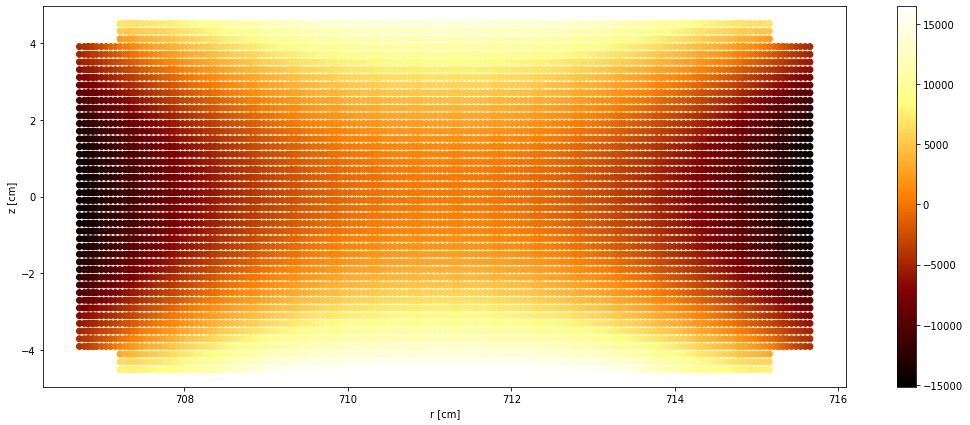

In [179]:
# Plot V in color code vs r,z
fig=plt.figure('V_color', figsize=(18, 7))
plt.scatter(
    r,z,c=V, cmap='afmhot'
)
plt.xlabel('r [cm]')
plt.ylabel('z [cm]')
plt.colorbar()

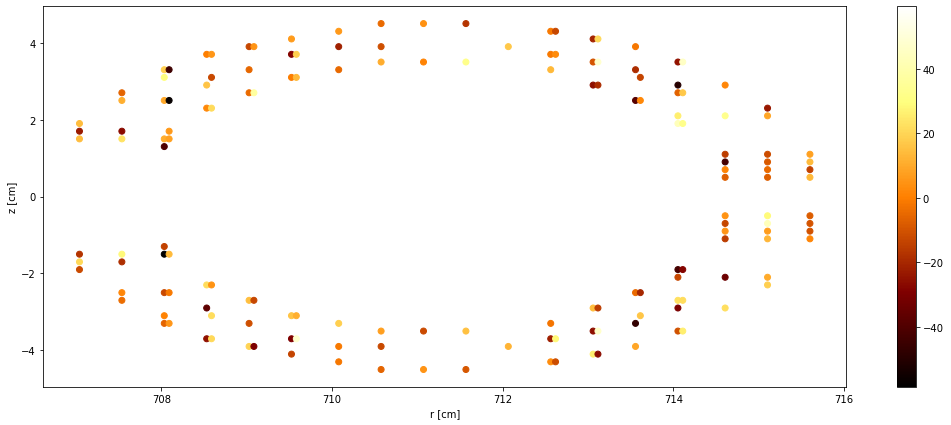

In [180]:
# Plot residuals in r,z color code
coordinates = np.vstack((r_polar[cut],th_polar[cut])).T
residuals = np.array(residual(fit_result.x,coordinates,V[cut],err_V,n_order) )

fig=plt.figure('residual_color', figsize=(18, 7))
plt.scatter(
    r[cut],z[cut],c=residuals, cmap='afmhot'
)
plt.xlabel('r [cm]')
plt.ylabel('z [cm]')
plt.colorbar()


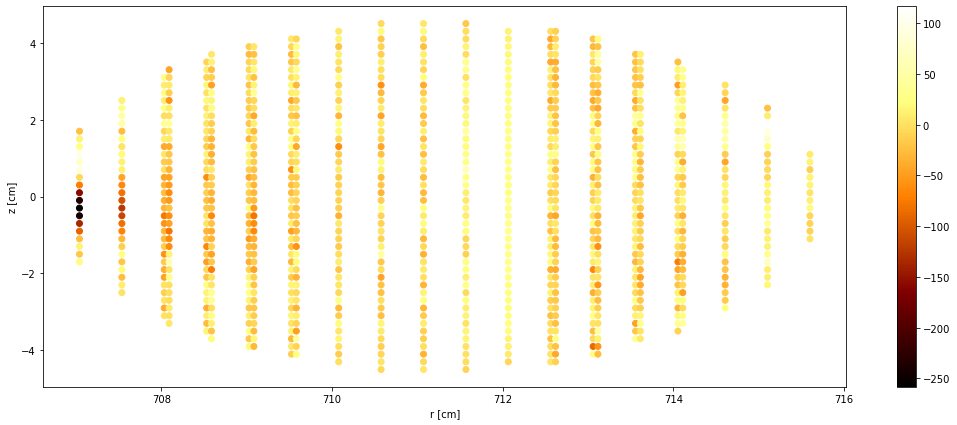

In [182]:
## same but with only the angle cut
cut2 = ( (np.abs(th-6.5)<0.03) & (r_polar<4.55) )

# Plot residuals in r,z color code
coordinates = np.vstack((r_polar[cut2],th_polar[cut2])).T
residuals = np.array(residual(fit_result.x,coordinates,V[cut2],err_V,n_order) )

fig=plt.figure('residual_color', figsize=(18, 7))
plt.scatter(
    r[cut2],z[cut2],c=residuals, cmap='afmhot'
)
plt.xlabel('r [cm]')
plt.ylabel('z [cm]')
plt.colorbar()



In [46]:
pars=0.000000000e+00, 2.830583297e+02, -2.520568872e+02, -6.386621195e+01, -2.136511972e-02, -7.752691363e+02, 3.345295877e+00, -7.913511083e-01, 4.311644429e-03, -7.498090412e-01, 2.654167993e-02, 7.122382250e-03, -2.551581584e-04, 5.016072655e-02, -1.804775553e-03, 3.972955749e-04, -8.689912191e-06, 2.616954752e-04, 6.742988413e-05, 2.270215935e-05, 1.757005579e-07, 4.424797074e-05


In [62]:
pars=fit_result.x

In [68]:
residuals = np.array(residual(best_pars,coordinates,V,err_V,n_order) )

In [74]:

pars22 = [  0.00000000e+00,
  3.07128643e+02,
  -2.84690296e+02,
  -8.16698876e+01,
 -4.24301484e-01,
 -7.74193459e+02,
 3.34071154e+00,
 -1.00894349e+00,
 -1.89235514e-03,
 -7.17343894e-01,
 1.67706318e-02,
 1.92383032e-02,
 -1.56055441e-03,
 6.44090056e-02,
 -1.50629479e-03,
 -5.97803172e-04,
 -1.57289586e-04,
 6.42032769e-04,
 1.48695149e-04,
 2.70037120e-05,
  5.30016522e-06,
  6.01564612e-05,
  -1.58645566e-07,
  -1.27803465e-06,
  4.25402718e-08,
  1.33251487e-07,
  1.54080834e-10,
  1.94925547e-08,
  6.70488566e-09,
  -1.34859814e-08,
  4.09311386e-13,
  -6.68754789e-13,
  3.89861284e-13,
  1.15207442e-13,
  -2.67532909e-13,
  -3.00775705e-13,
  9.12888542e-14,
  -8.16359169e-14,
  -1.91821244e-13,
  3.56337980e-13,
 -4.25970188e-13,
 4.92467210e-13,
 1.20500575e-13,
 -1.41216730e-14,
 -6.46609221e-15,
 2.65013687e-14 ]

## Now with data cuts 

If the plates were exactly at their design location, then the field between them could be predicted by simple formulas and smooth functions.  
But, as you discovered with your data analysis, the plates can often be shifted from their design location!


We can use fancy software tools to predict the electric field everywhere between the plates, given the plates' location as we surveyed it.  
Below is a picture of the plates from that software.

<img src="https://github.com/ManolisKar/TARGET_2021_project/blob/main/quads_OPERA3D.png?raw=true" />


First we place the plates in their exact location, as was found in the survey data. The software breaks up the plates into tiny fragments, as you can see in the picture.  
Then for any point in the storage volume, it calculates the field generated from each fragment. The total field in that point will just be the sum of the field generated by all fragments. 

### Data file location


Here is the url to the data file for the field inside the plates:  
https://raw.githubusercontent.com/ManolisKar/TARGET_2021_project/main/quad_field.dat

###  <font color='red'>  Project work \#1: </font>  


By now you are data analysis experts, so go ahead and explore the field data:

* Open the file
* Read and examine the data 

There are 11 variables in the file, for each measurement point:
* The coordinates of the measurement point. They are given in x,y,z coordinates. The r, theta("th") cylindrical coordinates are also given, they are equivalent with (x,y).
    * Careful, the coordinates are now in cm, whereas in the survey files they were in m! If you feel like it you can easily convert them to m after you read them into variables.
* The potential and field measurements at each point. They consist of the potential V (in units of Volts), and the electric field components along each coordinate: E_x, E_y, E_z, E_r, E_theta  

The first line of the file lists (noted as special by the first character '!' lists all these 11 variables.

**Careful!**  
Data formats can be weird. In this file I think there is something different about how the end-of-line is marked.  
If you get an error, try replacing ".split('/n')" with ".splitlines()", which is a more general way to split the lines.

After you read in the data, plot all variables to have a first idea what you're looking at.

In [3]:
try:
    import urllib.request as urllib2
except ImportError:
    import urllib2
bottomquad_url = 'https://raw.githubusercontent.com/ManolisKar/TARGET_2021_project/main/quad_field.dat'
datafile = urllib2.urlopen(bottomquad_url)

In [4]:
file_content = datafile.read().decode('utf-8')
print(file_content)
datafile.close()

!x y z r th V Ex Ey Ez Er Et
702.0 81.5 -3.9 706.71511233311 6.62221416622196 -4149.69909027947 -5871.38027121489 -763.315133362845 810.203146577335 -5920.23442083949 -81.1214172673316
702.0 81.5 -3.7 706.71511233311 6.62221416622196 -4326.94354364725 -5879.56691351971 -734.226388816127 2757.9949678664 -5925.01186249668 -51.2826468043353
702.0 81.5 -3.5 706.71511233311 6.62221416622196 -5033.86352406033 -5891.03389059239 -711.098805457203 3885.65438668994 -5933.73520766602 -26.9869697348243
702.0 81.5 -3.3 706.71511233311 6.62221416622196 -5839.77797683265 -5515.17098370005 -629.875293364639 4641.18200528858 -5551.01312891913 10.3492611123473
702.0 81.5 -3.1 706.71511233311 6.62221416622196 -6894.39033000881 -5880.15819386207 -676.060322349359 5239.42013327564 -5918.89135432978 6.56353094699607
702.0 81.5 -2.9 706.71511233311 6.62221416622196 -7986.87632991062 -6326.99143478846 -739.38768102678 5757.03428578647 -6370.04643690604 -4.81148639133343
702.0 81.5 -2.7 706.71511233311 6.62221

In [5]:
x, y, z, r, th, V, Ex, Ey, Ez, Er, Et = [], [], [], [],[],[],[],[],[],[],[]
i=0
for line in file_content.splitlines():

    #if line[0]=='!': continue
    try:
        print (i, line)
        x_t, y_t, z_t, r_t, th_t, V_t, Ex_t, Ey_t, Ez_t, Er_t, Et_t = line.split()
        x.append(float(x_t))
        y.append(float(y_t))
        r.append(float(r_t))
        th.append(float(th_t))
        z.append(float(z_t))
        V.append(float(V_t))
        Ex.append(float(Ex_t))
        Ey.append(float(Ey_t))
        Er.append(float(Er_t))
        Et.append(float(Et_t))
        Ez.append(float(Ez_t))
        print (x_t,th_t,z_t)
        i+=1
    except ValueError:
        continue


0 !x y z r th V Ex Ey Ez Er Et
0 702.0 81.5 -3.9 706.71511233311 6.62221416622196 -4149.69909027947 -5871.38027121489 -763.315133362845 810.203146577335 -5920.23442083949 -81.1214172673316
702.0 6.62221416622196 -3.9
1 702.0 81.5 -3.7 706.71511233311 6.62221416622196 -4326.94354364725 -5879.56691351971 -734.226388816127 2757.9949678664 -5925.01186249668 -51.2826468043353
702.0 6.62221416622196 -3.7
2 702.0 81.5 -3.5 706.71511233311 6.62221416622196 -5033.86352406033 -5891.03389059239 -711.098805457203 3885.65438668994 -5933.73520766602 -26.9869697348243
702.0 6.62221416622196 -3.5
3 702.0 81.5 -3.3 706.71511233311 6.62221416622196 -5839.77797683265 -5515.17098370005 -629.875293364639 4641.18200528858 -5551.01312891913 10.3492611123473
702.0 6.62221416622196 -3.3
4 702.0 81.5 -3.1 706.71511233311 6.62221416622196 -6894.39033000881 -5880.15819386207 -676.060322349359 5239.42013327564 -5918.89135432978 6.56353094699607
702.0 6.62221416622196 -3.1
5 702.0 81.5 -2.9 706.71511233311 6.622214

702.5 6.33571586282292 2.1
191 702.5 78.0 2.3 706.816984798753 6.33571586282292 -10858.8387599778 -7416.38363430225 -846.619766091132 -4378.38827256978 -7464.51480131686 -23.0221720097422
702.5 6.33571586282292 2.3
192 702.5 78.0 2.5 706.816984798753 6.33571586282292 -9894.59333950038 -6904.69877335432 -814.158854323149 -4996.36638726419 -6952.37294038394 -47.2259319714555
702.5 6.33571586282292 2.5
193 702.5 78.0 2.7 706.816984798753 6.33571586282292 -8895.13249731069 -6362.35037483193 -713.832152873053 -5393.36764718325 -6402.26557024796 -7.36224265735589
702.5 6.33571586282292 2.7
194 702.5 78.0 2.9 706.816984798753 6.33571586282292 -7771.96430568916 -5741.50019827155 -616.091210866983 -5249.03756069906 -5774.42123139624 21.2685039471785
702.5 6.33571586282292 2.9
195 702.5 78.0 3.1 706.816984798753 6.33571586282292 -6701.62290191611 -5500.293582528 -590.846451538401 -4908.62199409075 -5531.90196194733 19.7409902867997
702.5 6.33571586282292 3.1
196 702.5 78.0 3.3 706.816984798753 6

702.5 6.4565372801036 -1.9
291 702.5 79.5 -1.7 706.984087515412 6.4565372801036 -11306.9112151142 -7319.32788212955 -830.071762151593 2483.26087224179 -7366.24576741062 -1.75229726392966
702.5 6.4565372801036 -1.7
292 702.5 79.5 -1.5 706.984087515412 6.4565372801036 -11750.2648659151 -7068.69197017145 -797.275340235793 1935.12167239773 -7113.51158732347 2.6522309993928
702.5 6.4565372801036 -1.5
293 702.5 79.5 -1.3 706.984087515412 6.4565372801036 -12094.820808902 -6911.10567967947 -762.543636776228 1583.98842979081 -6953.01923466753 19.4431486393498
702.5 6.4565372801036 -1.3
294 702.5 79.5 -1.1 706.984087515412 6.4565372801036 -12390.9026830688 -6702.43340676766 -732.870308194033 1274.66897828316 -6742.33372706821 25.4631817739856
702.5 6.4565372801036 -1.1
295 702.5 79.5 -0.9 706.984087515412 6.4565372801036 -12590.1215736786 -6527.31269744739 -729.89824491188 1018.10884032618 -6567.98952398778 8.72416014078619
702.5 6.4565372801036 -0.9
296 702.5 79.5 -0.7 706.984087515412 6.456537

702.5 6.53705293427256 2.1
391 702.5 80.5 2.3 707.097235180566 6.53705293427256 -8860.47071123968 -6656.06547216076 -784.224887129579 -3959.27879829522 -6702.07131611355 -21.3615779387555
702.5 6.53705293427256 2.3
392 702.5 80.5 2.5 707.097235180566 6.53705293427256 -8016.1547608316 -6346.15065978366 -730.668166736847 -4473.61384362422 -6388.07422965934 -3.43553743274029
702.5 6.53705293427256 2.5
393 702.5 80.5 2.7 707.097235180566 6.53705293427256 -7074.97849045491 -6136.24277445653 -709.967765168087 -4660.03776467902 -6177.17442076599 -6.76683693383153
702.5 6.53705293427256 2.7
394 702.5 80.5 2.9 707.097235180566 6.53705293427256 -6126.89158217684 -5950.99615489856 -701.801150365199 -4816.47573056252 -5992.20245902765 -19.742854260564
702.5 6.53705293427256 2.9
395 702.5 80.5 3.1 707.097235180566 6.53705293427256 -5156.366120429 -5811.28081513225 -692.773209683776 -4865.52904737518 -5852.36769445607 -26.6796039442713
702.5 6.53705293427256 3.1
396 702.5 80.5 3.3 707.097235180566 6

702.5 6.65777771543407 -3.7
491 702.5 82.0 -3.5 707.269573783575 6.65777771543407 -1306.02917299611 -7057.87303552362 -799.388085686248 5443.47819206048 -7102.95736830166 24.2841758715377
702.5 6.65777771543407 -3.5
492 702.5 82.0 -3.3 707.269573783575 6.65777771543407 -2369.46195972103 -6582.96534227407 -752.821757159157 5339.60129529122 -6625.85343798288 15.4762399909421
702.5 6.65777771543407 -3.3
493 702.5 82.0 -3.1 707.269573783575 6.65777771543407 -3444.62936338571 -6163.59597779658 -717.177759766082 5227.91865920892 -6205.17962793897 2.25867760025579
702.5 6.65777771543407 -3.1
494 702.5 82.0 -2.9 707.269573783575 6.65777771543407 -4425.99519183363 -6231.48611171914 -730.37593992449 4959.16468093802 -6274.14211644623 -2.97939670260723
702.5 6.65777771543407 -2.9
495 702.5 82.0 -2.7 707.269573783575 6.65777771543407 -5406.34198749886 -6300.02419853959 -741.218198587495 4754.54250298405 -6343.47504552928 -5.80231410990154
702.5 6.65777771543407 -2.7
496 702.5 82.0 -2.5 707.2695737

702.5 6.73822799154863 -2.1
591 702.5 83.0 -1.9 707.386209930615 6.73822799154863 -7977.24693464396 -6478.69238736425 -778.328900744733 3145.34495361219 -6525.26531629441 -12.7859216011997
702.5 6.73822799154863 -1.9
592 702.5 83.0 -1.7 707.386209930615 6.73822799154863 -8513.22042867382 -6416.76877691687 -759.020133334064 2703.94750627124 -6461.50387537122 -0.876233059646985
702.5 6.73822799154863 -1.7
593 702.5 83.0 -1.5 707.386209930615 6.73822799154863 -9000.83359618453 -6330.82181077675 -730.767208821715 2298.5520194932 -6372.83557004179 17.0970905672614
702.5 6.73822799154863 -1.5
594 702.5 83.0 -1.3 707.386209930615 6.73822799154863 -9449.11259685756 -6211.88925548925 -701.18959510122 1913.74962899905 -6251.25409047534 32.5156432569655
702.5 6.73822799154863 -1.3
595 702.5 83.0 -1.1 707.386209930615 6.73822799154863 -9763.12935466694 -6071.80226180441 -682.168046234275 1602.00590928632 -6109.90287353633 34.9689248997574
702.5 6.73822799154863 -1.1
596 702.5 83.0 -0.9 707.3862099

703.0 6.37149846799852 -0.5
691 703.0 78.5 -0.3 707.369245868097 6.37149846799852 -10691.2568453787 -5743.44525003969 -644.671800993912 442.366717298311 -5779.51157904631 -3.31343776153056
703.0 6.37149846799852 -0.3
692 703.0 78.5 -0.0999999999999996 707.369245868097 6.37149846799852 -10778.9113733874 -5692.77296094698 -637.801013612112 196.110683645076 -5728.38979752574 -2.10842518767703
703.0 6.37149846799852 -0.0999999999999996
693 703.0 78.5 0.100000000000001 707.369245868097 6.37149846799852 -10819.4629333772 -5665.36510392492 -627.06342996431 -17.5600342086966 -5699.95963333591 5.52125981728726
703.0 6.37149846799852 0.100000000000001
694 703.0 78.5 0.300000000000001 707.369245868097 6.37149846799852 -10756.6255260674 -5685.11835929671 -629.903400240166 -240.31905438604 -5719.90604219584 4.89094041925618
703.0 6.37149846799852 0.300000000000001
695 703.0 78.5 0.5 707.369245868097 6.37149846799852 -10674.9335537321 -5716.23466669368 -638.458581701456 -479.260888077645 -5751.77955

778 703.0 79.5 -1.3 707.480918470597 6.45198388437409 -8883.14588779311 -5947.81178758817 -670.359027831667 1982.95759921553 -5985.46917497265 2.24548889746992
703.0 6.45198388437409 -1.3
779 703.0 79.5 -1.1 707.480918470597 6.45198388437409 -9266.75499919074 -5856.79072591765 -678.677469594307 1635.10847008181 -5895.95935416909 -16.2483511770111
703.0 6.45198388437409 -1.1
780 703.0 79.5 -0.9 707.480918470597 6.45198388437409 -9578.87359632868 -5770.09299606072 -664.370906573379 1291.13652132436 -5808.20309922471 -11.7746697003028
703.0 6.45198388437409 -0.9
781 703.0 79.5 -0.7 707.480918470597 6.45198388437409 -9768.70460906088 -5690.52785166278 -652.723195630587 1008.42550033357 -5727.83303121691 -9.14150778100554
703.0 6.45198388437409 -0.7
782 703.0 79.5 -0.5 707.480918470597 6.45198388437409 -9959.5495517873 -5609.30447641212 -643.480103936576 723.783095479187 -5646.08544328774 -9.08407142137855
703.0 6.45198388437409 -0.5
783 703.0 79.5 -0.3 707.480918470597 6.45198388437409 -10

890 703.0 80.5 2.7 707.593986690107 6.5324437375441 -4189.28453249145 -5402.85670825357 -627.826783592161 -4380.56010493981 -5439.20439457748 -9.09033142150449
703.0 6.5324437375441 2.7
891 703.0 80.5 2.9 707.593986690107 6.5324437375441 -3289.51805644599 -5338.38761399836 -616.813310203882 -4675.78188193986 -5373.90090311436 -5.48274041249126
703.0 6.5324437375441 2.9
892 703.0 80.5 3.1 707.593986690107 6.5324437375441 -2326.76665347669 -5355.41501254163 -610.827105326198 -4965.50426850654 -5390.13672747036 2.40173531325962
703.0 6.5324437375441 3.1
893 703.0 80.5 3.3 707.593986690107 6.5324437375441 -1315.77463216628 -5332.1571858062 -599.708171226023 -5311.96841556451 -5365.76494546761 10.8025353935815
703.0 6.5324437375441 3.3
894 703.0 80.5 3.5 707.593986690107 6.5324437375441 -174.932765647225 -5387.48603125681 -591.007249018785 -5858.32801016767 -5419.74470622387 25.7414983713602
703.0 6.5324437375441 3.5
895 703.0 80.5 3.7 707.593986690107 6.5324437375441 1025.51545975264 -5501

990 703.0 81.5 4.3 707.708449857708 6.61287772249955 5923.84504224807 -2808.26478328071 -380.460266973237 -7056.12176923381 -2833.39510049347 -54.5280868874281
703.0 6.61287772249955 4.3
991 703.0 81.5 4.5 707.708449857708 6.61287772249955 7227.08529391622 -2364.63889333769 -351.407297698427 -6421.09532749556 -2389.37494263182 -76.7565520602361
703.0 6.61287772249955 4.5
992 703.0 82.0 -4.5 707.766204335867 6.65308491924646 8570.39150289653 -3275.15441324052 -337.769058215792 6015.57786763232 -3292.23209727605 43.9566254639322
703.0 6.65308491924646 -4.5
993 703.0 82.0 -4.3 707.766204335867 6.65308491924646 7340.84850605782 -3719.69141954093 -378.90330406467 6946.74521899215 -3738.54123390006 54.6023155784282
703.0 6.65308491924646 -4.3
994 703.0 82.0 -4.1 707.766204335867 6.65308491924646 5898.20657007823 -4499.27569026645 -484.334403515229 7246.43956782211 -4525.09064677767 40.2018643392876
703.0 6.65308491924646 -4.1
995 703.0 82.0 -3.9 707.766204335867 6.65308491924646 4447.5081444

1090 703.0 83.0 -3.3 707.882758654285 6.73347953131106 1301.57417058327 -5304.03351712345 -628.273420564852 5705.53119819149 -5341.11363812884 -2.03625913786282
703.0 6.73347953131106 -3.3
1091 703.0 83.0 -3.1 707.882758654285 6.73347953131106 181.362202786389 -5310.36023923275 -624.865813524538 5357.28412505969 -5346.99717492583 2.08965811143655
703.0 6.73347953131106 -3.1
1092 703.0 83.0 -2.9 707.882758654285 6.73347953131106 -925.163870183819 -5320.07504905736 -620.047143918298 5002.3191926951 -5356.07998087184 8.01416170663954
703.0 6.73347953131106 -2.9
1093 703.0 83.0 -2.7 707.882758654285 6.73347953131106 -1859.22973643272 -5331.07212256134 -600.865444995482 4636.6955160432 -5364.75212549981 28.3529696060432
703.0 6.73347953131106 -2.7
1094 703.0 83.0 -2.5 707.882758654285 6.73347953131106 -2731.311240141 -5353.71510323341 -593.322791676681 4307.44663461332 -5386.35453776379 38.4985093738886
703.0 6.73347953131106 -2.5
1095 703.0 83.0 -2.3 707.882758654285 6.73347953131106 -3581

703.5 6.36700724138403 -3.5
1182 703.5 78.5 -3.3 707.866159665794 6.36700724138403 1184.7000258726 -5329.2608506309 -596.579022338184 5770.56133913898 -5362.54828662043 -1.90200565742858
703.5 6.36700724138403 -3.3
1183 703.5 78.5 -3.1 707.866159665794 6.36700724138403 54.7122028349828 -5343.90675161953 -601.631212479016 5377.20508197511 -5377.66412190292 -5.29885194487215
703.5 6.36700724138403 -3.1
1184 703.5 78.5 -2.9 707.866159665794 6.36700724138403 -984.922473592839 -5369.41862360164 -597.951306544812 5007.557480794 -5402.61054585955 1.18753776681492
703.5 6.36700724138403 -2.9
1185 703.5 78.5 -2.7 707.866159665794 6.36700724138403 -1936.47026717415 -5372.27819995438 -598.408634177323 4659.09126288087 -5405.50320029054 1.05014845323708
703.5 6.36700724138403 -2.7
1186 703.5 78.5 -2.5 707.866159665794 6.36700724138403 -2822.51651844312 -5389.11835129006 -609.706445571068 4328.34291047253 -5423.49237025604 -8.31046067487498
703.5 6.36700724138403 -2.5
1187 703.5 78.5 -2.3 707.86615

703.5 6.44743687946151 4.3
1313 703.5 79.5 4.5 707.97775388779 6.44743687946151 7940.74425731689 -3263.04967161587 -352.782430489769 -5959.54660378284 -3282.02635527158 15.862093098605
703.5 6.44743687946151 4.5
1314 703.5 80.0 -4.5 708.034074038814 6.48764215141861 9633.23979448511 -4251.05466662279 -510.730903865867 5669.62442099514 -4281.53889965502 -27.1382667082774
703.5 6.48764215141861 -4.5
1315 703.5 80.0 -4.3 708.034074038814 6.48764215141861 8414.41631432502 -4530.53424712802 -519.174890396098 6334.31186959669 -4560.18283932089 -3.95008619777274
703.5 6.48764215141861 -4.3
1316 703.5 80.0 -4.1 708.034074038814 6.48764215141861 7138.82764989699 -4499.41264619501 -503.936855315244 6598.13120806339 -4527.53880436506 7.67397245493171
703.5 6.48764215141861 -4.1
1317 703.5 80.0 -3.9 708.034074038814 6.48764215141861 5805.85853796221 -4672.9808476516 -530.343843068401 6493.42507628051 -4702.97921507353 1.04737079852399
703.5 6.48764215141861 -3.9
1318 703.5 80.0 -3.7 708.0340740388

703.5 6.6082193222613 2.9
1490 703.5 81.5 3.1 708.205125652166 6.6082193222613 651.264468806147 -4251.78341152657 -481.211362984138 -4857.92918520947 -4278.91333503353 11.2794357040534
703.5 6.6082193222613 3.1
1491 703.5 81.5 3.3 708.205125652166 6.6082193222613 1662.62314119655 -4146.34888123773 -465.857169144064 -5201.86622417452 -4172.41232829949 14.3982512391963
703.5 6.6082193222613 3.3
1492 703.5 81.5 3.5 708.205125652166 6.6082193222613 2740.3342486622 -4080.11510868338 -472.145993313143 -5534.20180909215 -4107.34231093725 0.529048785906534
703.5 6.6082193222613 3.5
1493 703.5 81.5 3.7 708.205125652166 6.6082193222613 3845.94652744765 -3985.54130678639 -477.67181479536 -5870.44236634926 -4014.03274173176 -15.8435809047724
703.5 6.6082193222613 3.7
1494 703.5 81.5 3.9 708.205125652166 6.6082193222613 5074.0468519888 -3771.40523816314 -459.973206664573 -6068.2538133184 -3799.28258626082 -22.9052620359017
703.5 6.6082193222613 3.9
1495 703.5 81.5 4.1 708.205125652166 6.60821932226

1667 704.0 78.0 1.7 708.307842678591 6.322325896937 -4069.10808381089 -4349.54288365367 -478.813029199948 -2478.02726799647 -4375.81715126682 3.07771880652736
704.0 6.322325896937 1.7
1668 704.0 78.0 1.9 708.307842678591 6.322325896937 -3552.72731899578 -4339.19089997773 -471.973903824035 -2800.49697217923 -4364.77499160696 8.73527233969925
704.0 6.322325896937 1.9
1669 704.0 78.0 2.1 708.307842678591 6.322325896937 -2950.10101238477 -4323.57645614253 -473.567161496803 -3155.05186314541 -4349.43096503173 5.43221697336758
704.0 6.322325896937 2.1
1670 704.0 78.0 2.3 708.307842678591 6.322325896937 -2267.46844271131 -4302.41008721048 -451.35569627684 -3507.00659315096 -4325.94736508681 25.177720122484
704.0 6.322325896937 2.3
1671 704.0 78.0 2.5 708.307842678591 6.322325896937 -1558.84792719353 -4261.68350048765 -417.302546849895 -3859.71240482212 -4281.71848490146 54.5388851119071
704.0 6.322325896937 2.5
1672 704.0 78.0 2.7 708.307842678591 6.322325896937 -730.572829900692 -4214.147443

704.0 6.44289625197794 -1.5
1790 704.0 79.5 -1.3 708.474593757603 6.44289625197794 -3797.1819128355 -4269.2864872218 -451.125964300365 2201.02355837719 -4292.94462774571 30.7923488843406
704.0 6.44289625197794 -1.3
1791 704.0 79.5 -1.1 708.474593757603 6.44289625197794 -4156.91079467354 -4251.05000200304 -458.116161705737 1889.58830983881 -4275.60771120911 21.7999310836084
704.0 6.44289625197794 -1.1
1792 704.0 79.5 -0.9 708.474593757603 6.44289625197794 -4517.59591392289 -4228.75081565265 -469.852724774791 1576.26523594537 -4254.76635633657 7.63523724152598
704.0 6.44289625197794 -0.9
1793 704.0 79.5 -0.7 708.474593757603 6.44289625197794 -4842.174773387 -4188.51937946544 -480.232847366871 1256.58789728973 -4215.95379824061 -7.19381319200608
704.0 6.44289625197794 -0.7
1794 704.0 79.5 -0.5 708.474593757603 6.44289625197794 -5033.46187285789 -4177.19819614369 -476.868005580032 944.885487184561 -4204.32653869856 -5.12060611189684
704.0 6.44289625197794 -0.5
1795 704.0 79.5 -0.3 708.4745

704.0 6.56340933059258 2.5
1948 704.0 81.0 2.7 708.644480681251 6.56340933059258 589.03746621329 -3641.63997516611 -433.208218579154 -4122.82966692993 -3667.28942236805 -14.1195594745208
704.0 6.56340933059258 2.7
1949 704.0 81.0 2.9 708.644480681251 6.56340933059258 1479.3971896831 -3603.14542320319 -420.717493702252 -4425.00492688308 -3627.61944106812 -6.1107316926596
704.0 6.56340933059258 2.9
1950 704.0 81.0 3.1 708.644480681251 6.56340933059258 2362.6616650145 -3568.12295976519 -414.529131127667 -4729.15108585635 -3592.11916933143 -3.96609110705988
704.0 6.56340933059258 3.1
1951 704.0 81.0 3.3 708.644480681251 6.56340933059258 3367.06417763743 -3519.58016593301 -398.536917617464 -5051.99097174457 -3542.06657297438 6.37273493407792
704.0 6.56340933059258 3.3
1952 704.0 81.0 3.5 708.644480681251 6.56340933059258 4374.88314665645 -3462.46568519824 -384.527751042981 -5378.84153729763 -3483.72513653214 13.7617437694903
704.0 6.56340933059258 3.5
1953 704.0 81.0 3.7 708.644480681251 6.

704.0 6.64371905659262 4.1
2048 704.0 82.0 4.3 708.759479654417 6.64371905659262 9523.86952064442 -3267.5589336493 -403.001063289929 -6436.62067264296 -3292.24178788638 -22.25425754384
704.0 6.64371905659262 4.3
2049 704.0 82.0 4.5 708.759479654417 6.64371905659262 10824.5165905537 -3519.06730473987 -440.332917711693 -6670.75010088432 -3546.38033626696 -30.2371336053418
704.0 6.64371905659262 4.5
2050 704.0 82.5 -4.5 708.817501194772 6.68386410803412 13857.5468404597 -5500.50674564913 -573.920270835832 8606.5204602761 -5529.92154493074 70.1900499970244
704.0 6.68386410803412 -4.5
2051 704.0 82.5 -4.3 708.817501194772 6.68386410803412 12220.4579687124 -4594.96844666011 -480.098313557793 7891.83735772144 -4619.6177320648 57.977806749272
704.0 6.68386410803412 -4.3
2052 704.0 82.5 -4.1 708.817501194772 6.68386410803412 10637.7488003963 -4014.32302139633 -467.561921407383 7246.86580675657 -4041.45955870235 2.84707501013724
704.0 6.68386410803412 -4.1
2053 704.0 82.5 -3.9 708.817501194772 6

704.5 6.31787509224642 4.1
2186 704.5 78.0 4.3 708.804803877626 6.31787509224642 9616.10543497245 -3201.01825233466 -344.89859032024 -6409.04824421368 -3219.53157813069 9.45022771410349
704.5 6.31787509224642 4.3
2187 704.5 78.0 4.5 708.804803877626 6.31787509224642 10926.0966278919 -3353.43117579678 -374.569843641721 -6741.18428191811 -3374.28400325262 -3.26863350921057
704.5 6.31787509224642 4.5
2188 704.5 78.5 -4.5 708.860000282143 6.35804367850346 14088.2320039543 -5229.69334968587 -509.426687116589 8782.71884574674 -5253.9414811246 72.8491195104108
704.5 6.35804367850346 -4.5
2189 704.5 78.5 -4.3 708.860000282143 6.35804367850346 12358.2678069551 -4359.50889196869 -447.335507709896 7718.08810432164 -4382.23323436327 38.1931309809335
704.5 6.35804367850346 -4.3
2190 704.5 78.5 -4.1 708.860000282143 6.35804367850346 10803.4786215002 -4114.10662453609 -424.675768722232 6961.24241016177 -4135.83100141562 33.5373570970415
704.5 6.35804367850346 -4.1
2191 704.5 78.5 -3.9 708.86000028214

704.5 6.43836198857263 -4.3
2282 704.5 79.5 -4.1 708.971438070674 6.43836198857263 11227.559649193 -3621.25550500397 -392.672980424896 7386.92551611173 -3642.44857627346 15.8704530736754
704.5 6.43836198857263 -4.1
2283 704.5 79.5 -3.9 708.971438070674 6.43836198857263 9851.49344511449 -3502.15442851448 -360.413299455954 6919.25347889598 -3520.48124673027 34.5713611071292
704.5 6.43836198857263 -3.9
2284 704.5 79.5 -3.7 708.971438070674 6.43836198857263 8491.2134954546 -3463.65362735282 -367.956561557829 6508.97043888687 -3483.06912593529 22.7584143600577
704.5 6.43836198857263 -3.7
2285 704.5 79.5 -3.5 708.971438070674 6.43836198857263 7194.1079751613 -3415.86775649083 -378.514519666264 6096.50813583919 -3436.76854654667 6.90861052099199
704.5 6.43836198857263 -3.5
2286 704.5 79.5 -3.3 708.971438070674 6.43836198857263 6061.93226229672 -3411.7627008652 -384.532173826916 5705.92167961621 -3433.3641665493 0.468591878152037
704.5 6.43836198857263 -3.3
2287 704.5 79.5 -3.1 708.97143807067

2392 704.5 80.5 -0.5 709.084268616925 6.51865489564495 -2813.20202009365 -3215.25574178773 -360.674397318431 975.684682331426 -3235.41511299977 6.67476985818582
704.5 6.51865489564495 -0.5
2393 704.5 80.5 -0.3 709.084268616925 6.51865489564495 -2952.4396218054 -3211.07565653866 -357.084173106869 677.904555341852 -3230.85446590869 9.7672317721587
704.5 6.51865489564495 -0.3
2394 704.5 80.5 -0.0999999999999996 709.084268616925 6.51865489564495 -3031.09956495345 -3216.64231863454 -355.779455158448 380.690562107708 -3236.23701890079 11.695479448626
704.5 6.51865489564495 -0.0999999999999996
2395 704.5 80.5 0.100000000000001 709.084268616925 6.51865489564495 -3075.88571738305 -3194.0605802452 -369.411719829158 67.2353199630442 -3215.34889876496 -4.41228221859406
704.5 6.51865489564495 0.100000000000001
2396 704.5 80.5 0.300000000000001 709.084268616925 6.51865489564495 -3059.1746061103 -3156.34251918318 -390.730680951297 -250.06121019064 -3180.29495842534 -29.8754222502533
704.5 6.518654895

704.5 6.59892209655393 -3.7
2469 704.5 81.5 -3.5 709.19849125615 6.59892209655393 7957.31845708445 -2936.73538312955 -351.500785546464 6083.63360644393 -2957.67322871982 -11.6869533630066
704.5 6.59892209655393 -3.5
2470 704.5 81.5 -3.3 709.19849125615 6.59892209655393 6734.36066913891 -2959.9073146488 -364.278097621618 5692.78584542763 -2982.15999357274 -21.7167320862081
704.5 6.59892209655393 -3.3
2471 704.5 81.5 -3.1 709.19849125615 6.59892209655393 5647.19622192001 -2996.1439957491 -363.169439800677 5314.4102293218 -3018.02919879017 -16.4511555366682
704.5 6.59892209655393 -3.1
2472 704.5 81.5 -2.9 709.19849125615 6.59892209655393 4622.6627297613 -3036.95256769933 -366.28675353808 4945.0605974259 -3058.92564790297 -14.8581585127428
704.5 6.59892209655393 -2.9
2473 704.5 81.5 -2.7 709.19849125615 6.59892209655393 3701.69581765291 -3052.93634685632 -377.308388399176 4607.00679807948 -3076.07012269697 -23.9699429257382
704.5 6.59892209655393 -2.7
2474 704.5 81.5 -2.5 709.19849125615 6

2590 704.5 82.5 2.3 709.314105315833 6.6791632887308 1308.13598723352 -2672.9038374846 -281.219146978033 -3357.20770277495 -2687.471345695 31.5737095577471
704.5 6.6791632887308 2.3
2591 704.5 82.5 2.5 709.314105315833 6.6791632887308 1964.01538997694 -2657.06567059772 -287.877243491286 -3640.73399012923 -2672.51507240231 23.1186714909601
704.5 6.6791632887308 2.5
2592 704.5 82.5 2.7 709.314105315833 6.6791632887308 2747.12504042082 -2612.53217341134 -305.868779295721 -3953.00202354848 -2630.3764107855 0.0695732570804337
704.5 6.6791632887308 2.7
2593 704.5 82.5 2.9 709.314105315833 6.6791632887308 3533.0356815866 -2579.50551102307 -319.304530727227 -4275.2607944108 -2599.13660603134 -17.1163059453364
704.5 6.6791632887308 2.9
2594 704.5 82.5 3.1 709.314105315833 6.6791632887308 4416.40516246391 -2554.00704161508 -319.602596402779 -4572.06654606858 -2573.84586227585 -20.3780639975826
704.5 6.6791632887308 3.1
2595 704.5 82.5 3.3 709.314105315833 6.6791632887308 5381.50085815719 -2518.9

705.0 6.43383407593194 -4.1
2789 705.0 79.5 -3.9 709.46828681767 6.43383407593194 11315.4947660337 -2241.64478810541 -247.953888510888 6844.84711857934 -2255.31139232181 4.79692935884425
705.0 6.43383407593194 -3.9
2790 705.0 79.5 -3.7 709.46828681767 6.43383407593194 9925.9711234426 -2335.19231560678 -256.2947758984 6417.90256982205 -2349.20439455108 6.99111175865876
705.0 6.43383407593194 -3.7
2791 705.0 79.5 -3.5 709.46828681767 6.43383407593194 8660.12352488248 -2433.07595548732 -264.078280803361 6024.02737048315 -2447.34374207293 10.2250525212507
705.0 6.43383407593194 -3.5
2792 705.0 79.5 -3.3 709.46828681767 6.43383407593194 7504.95576709882 -2528.43883040371 -285.368602999422 5648.32526399065 -2544.49171712872 -0.245223219600559
705.0 6.43383407593194 -3.3
2793 705.0 79.5 -3.1 709.46828681767 6.43383407593194 6449.06318063894 -2546.40785708241 -289.587751278272 5252.13359946591 -2562.82035328945 -2.4242662358382
705.0 6.43383407593194 -3.1
2794 705.0 79.5 -2.9 709.46828681767 6

2926 705.0 81.0 -4.1 709.637935851798 6.55418059039276 12988.7441340362 -1647.24011588019 -178.485509797093 7055.39507428134 -1656.84717316839 10.7014642195387
705.0 6.55418059039276 -4.1
2927 705.0 81.0 -3.9 709.637935851798 6.55418059039276 11637.2155688362 -1860.20016801313 -207.311923125006 6714.46640019523 -1871.70572078854 6.37128819854762
705.0 6.55418059039276 -3.9
2928 705.0 81.0 -3.7 709.637935851798 6.55418059039276 10333.0915870933 -1994.90834939817 -241.953068247555 6338.73502304609 -2009.48753274032 -12.6674975492735
705.0 6.55418059039276 -3.7
2929 705.0 81.0 -3.5 709.637935851798 6.55418059039276 9062.9503150664 -2113.8191115521 -257.063035203261 5952.27580917523 -2129.34582997162 -14.105914124452
705.0 6.55418059039276 -3.5
2930 705.0 81.0 -3.3 709.637935851798 6.55418059039276 7951.30139268164 -2180.78076845027 -254.262657233773 5606.02385716185 -2195.55020705483 -3.68065315195278
705.0 6.55418059039276 -3.3
2931 705.0 81.0 -3.1 709.637935851798 6.55418059039276 6841.

3061 705.0 82.0 4.5 709.752773858616 6.6343794086126 13138.7798509099 -1270.50602071838 -120.308289065502 -6553.32512755361 -1275.89783043274 27.2829506568228
705.0 6.6343794086126 4.5
3062 705.0 82.5 -4.5 709.810714204851 6.67446904711757 16080.0319063055 -672.761759113266 -93.4190681735522 7374.03518310299 -679.06007003448 -14.5920563443632
705.0 6.67446904711757 -4.5
3063 705.0 82.5 -4.3 709.810714204851 6.67446904711757 14648.3124452023 -983.92923398975 -130.379880563617 7133.55758806295 -992.414507152643 -15.1359422705117
705.0 6.67446904711757 -4.3
3064 705.0 82.5 -4.1 709.810714204851 6.67446904711757 13185.7500978423 -1308.49574181356 -164.483884134833 6813.24970369915 -1318.74512413958 -11.2850362147776
705.0 6.67446904711757 -4.1
3065 705.0 82.5 -3.9 709.810714204851 6.67446904711757 11833.0261601976 -1543.40442031374 -188.558678208704 6565.96543689912 -1554.85988755432 -7.89365861788891
705.0 6.67446904711757 -3.9
3066 705.0 82.5 -3.7 709.810714204851 6.67446904711757 10666.

3188 705.5 78.0 2.3 709.798739080311 6.30899218021952 2405.61467303471 -1990.52003228023 -234.417447784252 -3275.5142079846 -2004.22509279762 -14.2588966937952
705.5 6.30899218021952 2.3
3189 705.5 78.0 2.5 709.798739080311 6.30899218021952 3028.31408541466 -1955.50924300564 -233.305959797434 -3578.44811542191 -1969.30419687111 -17.0014865034641
705.5 6.30899218021952 2.5
3190 705.5 78.0 2.7 709.798739080311 6.30899218021952 3837.73523513805 -1923.01271330917 -226.37377146835 -3900.24007725434 -1936.24269492912 -13.6823350030027
705.5 6.30899218021952 2.7
3191 705.5 78.0 2.9 709.798739080311 6.30899218021952 4642.15782763996 -1885.64911415112 -216.495891416418 -4218.42618609522 -1898.01989689314 -7.9701754582237
705.5 6.30899218021952 2.9
3192 705.5 78.0 3.1 709.798739080311 6.30899218021952 5537.1188921979 -1829.78479357763 -200.381346843167 -4495.15506148957 -1840.72307400218 1.90782770754886
705.5 6.30899218021952 3.1
3193 705.5 78.0 3.3 709.798739080311 6.30899218021952 6426.029573

3366 705.5 80.0 1.1 710.021302497326 6.46940667622533 -18.4545586902462 -1731.93456651541 -210.856442888181 -1450.01132758135 -1744.66364283815 -14.3720408112927
705.5 6.46940667622533 1.1
3367 705.5 80.0 1.3 710.021302497326 6.46940667622533 298.546093596168 -1718.42356674798 -200.64719332162 -1758.26447751549 -1730.08837549779 -5.75012261491955
705.5 6.46940667622533 1.3
3368 705.5 80.0 1.5 710.021302497326 6.46940667622533 692.793387185166 -1703.04725029533 -197.358916115561 -2062.83951505915 -1714.43947398632 -4.21527535212682
705.5 6.46940667622533 1.5
3369 705.5 80.0 1.7 710.021302497326 6.46940667622533 1159.44457492204 -1687.01640410987 -200.580122257189 -2364.07777421239 -1698.87365158968 -9.22220770084824
705.5 6.46940667622533 1.7
3370 705.5 80.0 1.9 710.021302497326 6.46940667622533 1626.09576265891 -1670.98555792442 -203.801328398817 -2665.31603336563 -1683.30782919303 -14.2291400495695
705.5 6.46940667622533 1.9
3371 705.5 80.0 2.1 710.021302497326 6.46940667622533 2176.4

3488 705.5 81.5 -2.1 710.191875481549 6.58965087967937 3509.2043358164 -1463.36876772898 -171.731978035328 3515.90240864544 -1473.40860684045 -2.66456995544894
705.5 6.58965087967937 -2.1
3489 705.5 81.5 -1.9 710.191875481549 6.58965087967937 2861.03284110263 -1493.04403819517 -179.171212286128 3207.29702772684 -1503.74153748787 -6.64919061733053
705.5 6.58965087967937 -1.9
3490 705.5 81.5 -1.7 710.191875481549 6.58965087967937 2266.97380640886 -1507.58426812965 -174.741937194837 2912.64725060094 -1517.67741403126 -0.580573859862167
705.5 6.58965087967937 -1.7
3491 705.5 81.5 -1.5 710.191875481549 6.58965087967937 1675.10081663832 -1505.49249897483 -171.570852263865 2602.88070552011 -1515.23555765347 2.3295146725948
705.5 6.58965087967937 -1.5
3492 705.5 81.5 -1.3 710.191875481549 6.58965087967937 1208.00701015004 -1503.24315732162 -180.119591900531 2283.36694473325 -1513.98211011811 -6.42087712003286
705.5 6.58965087967937 -1.3
3493 705.5 81.5 -1.1 710.191875481549 6.58965087967937 76

705.5 6.66978136946108 1.1
3597 705.5 82.5 1.3 710.307327851825 6.66978136946108 719.155719024203 -1290.56091787319 -139.963757834327 -1747.82861423821 -1298.0828177141 10.8781709964733
705.5 6.66978136946108 1.3
3598 705.5 82.5 1.5 710.307327851825 6.66978136946108 1082.46364426335 -1283.52925017399 -149.14793860714 -2046.04668149298 -1292.16545422478 0.939441880791936
705.5 6.66978136946108 1.5
3599 705.5 82.5 1.7 710.307327851825 6.66978136946108 1525.8640101367 -1290.99585267629 -145.291463419284 -2367.00305574859 -1299.13360542961 5.6370394144716
705.5 6.66978136946108 1.7
3600 705.5 82.5 1.9 710.307327851825 6.66978136946108 2048.12001148136 -1281.01026569914 -145.928837706755 -2675.91349835931 -1289.2896295061 3.84418379340334
705.5 6.66978136946108 1.9
3601 705.5 82.5 2.1 710.307327851825 6.66978136946108 2628.46262404398 -1264.61511498821 -144.420028421733 -2958.58254023197 -1272.83019689975 3.43853546095463
705.5 6.66978136946108 2.1
3602 705.5 82.5 2.3 710.307327851825 6.669

706.0 6.34464536265283 -3.3
3713 706.0 78.5 -3.1 710.350793622419 6.34464536265283 8042.16321855518 -1112.72592450193 -129.972251175705 5052.04165820776 -1120.27371766216 -6.21020529047408
706.0 6.34464536265283 -3.1
3714 706.0 78.5 -2.9 710.350793622419 6.34464536265283 7080.28080529662 -1149.49310871136 -134.606719760112 4770.84131405705 -1157.32785777442 -6.75319174676298
706.0 6.34464536265283 -2.9
3715 706.0 78.5 -2.7 710.350793622419 6.34464536265283 6133.87991150801 -1192.90290623966 -137.50230086649 4470.64525326713 -1200.79176384593 -4.8338740559694
706.0 6.34464536265283 -2.7
3716 706.0 78.5 -2.5 710.350793622419 6.34464536265283 5227.31650597131 -1234.73947807482 -142.090561283606 4143.19438168561 -1242.87913592572 -4.77072351826464
706.0 6.34464536265283 -2.5
3717 706.0 78.5 -2.3 710.350793622419 6.34464536265283 4466.89120048832 -1256.32084192065 -148.436818629336 3844.16441930538 -1265.02963426833 -8.69318077347321
706.0 6.34464536265283 -2.3
3718 706.0 78.5 -2.1 710.3507

706.0 6.38472444292182 4.1
3796 706.0 79.0 4.3 710.406221819601 6.38472444292182 12520.9607648756 -642.278531211555 -75.5040461627924 -5822.29675647839 -646.691214929816 -3.61181046338045
706.0 6.38472444292182 4.3
3797 706.0 79.0 4.5 710.406221819601 6.38472444292182 13686.3676030456 -552.461099120527 -64.791459785201 -6018.91252770057 -556.239584008694 -2.95372381798078
706.0 6.38472444292182 4.5
3798 706.0 79.5 -4.5 710.461997576225 6.42479724987438 16397.7608254333 -201.908211056457 -26.3454470900442 6469.8967131207 -203.588172967688 -3.58665611289008
706.0 6.42479724987438 -4.5
3799 706.0 79.5 -4.3 710.461997576225 6.42479724987438 15061.1044994209 -414.450246098887 -47.7094298382221 6387.70754364797 -417.185964103805 -1.03321909324864
706.0 6.42479724987438 -4.3
3800 706.0 79.5 -4.1 710.461997576225 6.42479724987438 13818.3884107668 -553.50002086851 -63.923980997517 6203.48278404009 -557.17684066557 -1.5864028323056
706.0 6.42479724987438 -4.1
3801 706.0 79.5 -3.9 710.46199757622

706.0 6.50492389297751 3.1
3929 706.0 80.5 3.3 710.574591439914 6.50492389297751 7417.52088409879 -723.751243361165 -93.9233730019515 -4606.86657098859 -729.732269611398 -11.3259414926385
706.0 6.50492389297751 3.3
3930 706.0 80.5 3.5 710.574591439914 6.50492389297751 8376.73835777723 -698.98643464981 -92.3143494450422 -4851.31096244425 -704.944609654607 -12.5328471158023
706.0 6.50492389297751 3.5
3931 706.0 80.5 3.7 710.574591439914 6.50492389297751 9350.18787151081 -671.793250094359 -88.0660464212265 -5097.51570773697 -677.445207164055 -11.3925719246247
706.0 6.50492389297751 3.7
3932 706.0 80.5 3.9 710.574591439914 6.50492389297751 10397.6119695319 -639.075923857029 -75.5684010670084 -5343.83327805318 -643.522670297484 -2.68188492210989
706.0 6.50492389297751 3.9
3933 706.0 80.5 4.1 710.574591439914 6.50492389297751 11481.2016940417 -570.251672961784 -62.2492874578326 -5594.4003063117 -573.632597705744 2.75447891294234
706.0 6.50492389297751 4.1
3934 706.0 80.5 4.3 710.574591439914

706.0 6.58502499062372 3.5
4023 706.0 81.5 3.7 710.688574552877 6.58502499062372 9415.30801468368 -532.034033014696 -73.1783505672719 -5068.79216535101 -536.915994631932 -11.683235255358
706.0 6.58502499062372 3.7
4024 706.0 81.5 3.9 710.688574552877 6.58502499062372 10466.0932414973 -493.764260662196 -66.8076493023422 -5296.52459305634 -498.168120499748 -9.74324536994422
706.0 6.58502499062372 3.9
4025 706.0 81.5 4.1 710.688574552877 6.58502499062372 11546.6585995724 -440.652570628219 -60.3188644399211 -5514.6546037011 -444.662702667192 -9.38798515592009
706.0 6.58502499062372 4.1
4026 706.0 81.5 4.3 710.688574552877 6.58502499062372 12662.1610931585 -403.308644673202 -52.9267108242778 -5694.42802691489 -406.717429294979 -6.32710790925993
706.0 6.58502499062372 4.3
4027 706.0 81.5 4.5 710.688574552877 6.58502499062372 13806.4063735634 -336.823599976479 -40.7275783462769 -5862.12091403309 -339.272035392312 -1.83279563092452
706.0 6.58502499062372 4.5
4028 706.0 82.0 -4.5 710.7460868692

706.5 6.38024315807507 1.3
4288 706.5 79.0 1.5 710.903122795223 6.38024315807507 1559.09506165374 -369.650765737536 -24.3585085953071 -2044.0493474558 -370.068128464783 16.8702651403819
706.5 6.38024315807507 1.5
4289 706.5 79.0 1.7 710.903122795223 6.38024315807507 1993.51242021996 -370.850929421163 -27.9859004371095 -2363.55997952202 -371.663957153121 13.3987099789373
706.5 6.38024315807507 1.7
4290 706.5 79.0 1.9 710.903122795223 6.38024315807507 2539.64482904765 -385.28722929844 -39.4419198126259 -2638.25825623643 -387.283907379673 3.61789769166259
706.5 6.38024315807507 1.9
4291 706.5 79.0 2.1 710.903122795223 6.38024315807507 3073.2639274629 -396.852760412984 -50.5028502601637 -2916.55662014085 -400.006964780542 -6.08929050579914
706.5 6.38024315807507 2.1
4292 706.5 79.0 2.3 710.903122795223 6.38024315807507 3635.43901363063 -366.102577676879 -41.4422621358087 -3205.45764473394 -368.440370338466 -0.501973547495785
706.5 6.38024315807507 2.3
4293 706.5 79.0 2.5 710.903122795223 6

706.5 6.54038582819662 4.5
4488 706.5 81.5 -4.5 711.18527825033 6.58040556313462 16461.0387347875 -0.40436209267952 -0.364495775066417 6167.96869711947 -0.443468437538411 -0.315755628524132
706.5 6.58040556313462 -4.5
4489 706.5 81.5 -4.3 711.18527825033 6.58040556313462 15214.7399429854 -13.42945661876 -1.58838487660899 6123.56000457588 -13.5230083674656 -0.0389395024647359
706.5 6.58040556313462 -4.3
4490 706.5 81.5 -4.1 711.18527825033 6.58040556313462 14010.5507970349 -24.4301545900469 4.04411062183396 6008.04312761249 -23.8057644329209 6.81710083389547
706.5 6.58040556313462 -4.1
4491 706.5 81.5 -3.9 711.18527825033 6.58040556313462 12825.8039146532 -10.951356278578 7.70574463891559 5838.33235082821 -9.99615042683915 8.90997651088544
706.5 6.58040556313462 -3.9
4492 706.5 81.5 -3.7 711.18527825033 6.58040556313462 11672.8151906752 -16.3737656299994 0.033584201894695 5648.80169488057 -16.2620468376305 1.9097542919125
706.5 6.58040556313462 -3.7
4493 706.5 81.5 -3.5 711.18527825033 

4687 707.0 78.0 -1.5 711.289673761682 6.29571436040753 2387.86757636276 142.615639795753 3.64426122495327 2572.60855115382 142.155177336402 -12.0169426512589
707.0 6.29571436040753 -1.5
4688 707.0 78.0 -1.3 711.289673761682 6.29571436040753 1895.73787050196 106.835591707387 -2.68061173991064 2280.93342323467 105.897327628921 -14.3800325389231
707.0 6.29571436040753 -1.3
4689 707.0 78.0 -1.1 711.289673761682 6.29571436040753 1466.98118583214 106.979716349355 8.83776649004434 1957.10354662988 107.303688020065 -2.94692450081964
707.0 6.29571436040753 -1.1
4690 707.0 78.0 -0.9 711.289673761682 6.29571436040753 1122.81067179919 129.775664285796 15.3693633721573 1637.33664490889 130.678411935204 1.04547854025543
707.0 6.29571436040753 -0.9
4691 707.0 78.0 -0.7 711.289673761682 6.29571436040753 829.565986079804 131.380436822578 14.7051161536918 1324.10708189629 132.200665020559 0.209257991490073
707.0 6.29571436040753 -0.7
4692 707.0 78.0 -0.5 711.289673761682 6.29571436040753 579.24228034299

4887 707.0 80.0 1.7 711.511770809169 6.45579691786334 1984.45194478013 347.025297376916 52.2960544876477 -2343.05231267697 350.704766726083 12.9460777889001
707.0 6.45579691786334 1.7
4888 707.0 80.0 1.9 711.511770809169 6.45579691786334 2528.14245186749 339.377342537327 48.0966257203695 -2627.81874228787 342.633138667926 9.63318846225162
707.0 6.45579691786334 1.9
4889 707.0 80.0 2.1 711.511770809169 6.45579691786334 3083.31919890673 329.433549741196 43.3021062897802 -2910.80796934725 332.213320801975 5.98711833359318
707.0 6.45579691786334 2.1
4890 707.0 80.0 2.3 711.511770809169 6.45579691786334 3674.31922637752 318.032799269596 39.173671591862 -3189.92821544755 320.420676318087 3.16672466474629
707.0 6.45579691786334 2.3
4891 707.0 80.0 2.5 711.511770809169 6.45579691786334 4378.59705022169 316.148675961677 36.9612932836803 -3468.69359533403 318.29974802812 1.18021979267161
707.0 6.45579691786334 2.5
4892 707.0 80.0 2.7 711.511770809169 6.45579691786334 5063.4337882438 339.03739711

5087 707.0 82.5 -4.3 711.7971972409 6.65575758346814 15125.308867907 303.014064620082 41.6377775824591 6269.56437215631 305.797860936623 6.23667589146101
707.0 6.65575758346814 -4.3
5088 707.0 82.5 -4.1 711.7971972409 6.65575758346814 13881.7155319715 393.827655165842 57.0857952359563 6123.64863641881 397.789892130454 11.0549405239874
707.0 6.65575758346814 -4.1
5089 707.0 82.5 -3.9 711.7971972409 6.65575758346814 12671.7166070137 495.710462079234 63.858497604339 5945.72776034226 499.771036077825 5.97339340645346
707.0 6.65575758346814 -3.9
5090 707.0 82.5 -3.7 711.7971972409 6.65575758346814 11491.5173674994 590.599416727267 69.7164848254308 5750.78824924599 594.699444258999 0.793909970101804
707.0 6.65575758346814 -3.7
5091 707.0 82.5 -3.5 711.7971972409 6.65575758346814 10361.7966739333 669.001022946717 76.6884982468343 5515.68109995768 673.380741293472 -1.3681089731275
707.0 6.65575758346814 -3.5
5092 707.0 82.5 -3.3 711.7971972409 6.65575758346814 9289.38888098221 717.709553666321

5287 707.5 79.0 -1.1 711.896937765573 6.37129935602263 1108.65727164731 1083.14958393341 133.245984431727 1978.55925828617 1091.24610908049 12.2246864581582
707.5 6.37129935602263 -1.1
5288 707.5 79.0 -0.9 711.896937765573 6.37129935602263 743.366543360701 1081.75757705434 128.45767345866 1673.41284888652 1089.33133552058 7.62042241920103
707.5 6.37129935602263 -0.9
5289 707.5 79.0 -0.7 711.896937765573 6.37129935602263 442.671834327881 1088.87439638514 126.872897971656 1358.39358116769 1096.22833444359 5.25567368257506
707.5 6.37129935602263 -0.7
5290 707.5 79.0 -0.5 711.896937765573 6.37129935602263 205.570955808051 1096.12335259653 126.920087986705 1045.25974990427 1103.43775515954 4.49814745027391
707.5 6.37129935602263 -0.5
5291 707.5 79.0 -0.3 711.896937765573 6.37129935602263 25.8909847144988 1088.73095849492 122.22909441954 724.348708375101 1095.57045440071 0.656469435298872
707.5 6.37129935602263 -0.3
5292 707.5 79.0 -0.0999999999999996 711.896937765573 6.37129935602263 -86.60

707.5 6.53122139544038 1.9
5487 707.5 81.0 2.1 712.121653932809 6.53122139544038 2484.3516347031 1475.13621392377 165.732128595242 -2971.46712863046 1484.41374859108 -3.13226305417496
707.5 6.53122139544038 2.1
5488 707.5 81.0 2.3 712.121653932809 6.53122139544038 3111.54583392674 1458.81339578071 158.199175848792 -3264.00565410101 1467.34003240575 -8.75969451394557
707.5 6.53122139544038 2.3
5489 707.5 81.0 2.5 712.121653932809 6.53122139544038 3788.51031064512 1435.05649304972 156.025864992669 -3556.18020561948 1443.49010905666 -8.21668098757993
707.5 6.53122139544038 2.5
5490 707.5 81.0 2.7 712.121653932809 6.53122139544038 4531.89019429126 1402.93506733285 157.987508630787 -3846.01564180412 1411.8002770801 -2.61412932382806
707.5 6.53122139544038 2.7
5491 707.5 81.0 2.9 712.121653932809 6.53122139544038 5322.07696621917 1361.86101265414 159.150449388784 -4132.49360893216 1371.12507035971 3.21321631626118
707.5 6.53122139544038 2.9
5492 707.5 81.0 3.1 712.121653932809 6.531221395440

708.0 6.28689336173646 -4.1
5687 708.0 78.0 -3.9 712.283651363697 6.28689336173646 12251.1602607578 1197.51504734055 128.335234133697 6359.84609600389 1204.36682793035 -3.57277317966463
708.0 6.28689336173646 -3.9
5688 708.0 78.0 -3.7 712.283651363697 6.28689336173646 11020.330962654 1370.83899613609 148.177830690518 6048.43239455009 1378.82131392166 -2.82968388488099
708.0 6.28689336173646 -3.7
5689 708.0 78.0 -3.5 712.283651363697 6.28689336173646 9843.71214291072 1479.87534281419 158.855984325596 5777.07855990646 1488.37125134089 -4.15598453132692
708.0 6.28689336173646 -3.5
5690 708.0 78.0 -3.3 712.283651363697 6.28689336173646 8737.25774712125 1573.1845335276 159.559414501429 5487.82211082639 1581.19631401392 -13.6747883086923
708.0 6.28689336173646 -3.3
5691 708.0 78.0 -3.1 712.283651363697 6.28689336173646 7655.60233906033 1661.4590948586 161.438913999963 5185.73117858747 1669.14581315418 -21.4732687711058
708.0 6.28689336173646 -3.1
5692 708.0 78.0 -2.9 712.283651363697 6.28689

708.0 6.44675537910456 -4.3
5870 708.0 80.0 -4.1 712.505438575735 6.44675537910456 13307.5664100649 1324.33410787033 130.092714819444 6852.39008442912 1330.56663743203 -19.4259380884548
708.0 6.44675537910456 -4.1
5871 708.0 80.0 -3.9 712.505438575735 6.44675537910456 11929.6594389085 1597.4856218061 149.854168559743 6572.18489172403 1604.20972506304 -30.4588529844374
708.0 6.44675537910456 -3.9
5872 708.0 80.0 -3.7 712.505438575735 6.44675537910456 10684.3227450004 1765.69284952997 190.418300584178 6229.30066262044 1775.90784997139 -9.03750455810062
708.0 6.44675537910456 -3.7
5873 708.0 80.0 -3.5 712.505438575735 6.44675537910456 9441.36094591142 1930.67099859917 230.092113874208 5885.75581105279 1944.29735004879 11.8617154023407
708.0 6.44675537910456 -3.5
5874 708.0 80.0 -3.3 712.505438575735 6.44675537910456 8338.18362477956 1985.48202094956 240.530141198306 5544.74372928086 1999.93376187639 16.0795660947338
708.0 6.44675537910456 -3.3
5875 708.0 80.0 -3.1 712.505438575735 6.44675

708.0 6.52664876160445 2.7
5997 708.0 81.0 2.9 712.618411213182 6.52664876160445 4447.02823413502 2119.82575256181 248.010705460968 -4224.7175240392 2134.27758253795 5.45269873429658
708.0 6.52664876160445 2.9
5998 708.0 81.0 3.1 712.618411213182 6.52664876160445 5318.53538466802 2074.49248575367 237.51458551741 -4534.42872165435 2088.04507142515 0.177423426464189
708.0 6.52664876160445 3.1
5999 708.0 81.0 3.3 712.618411213182 6.52664876160445 6261.00892734823 2005.57374473838 223.082973672024 -4834.40883040986 2017.93261234169 -6.32698775820272
708.0 6.52664876160445 3.3
6000 708.0 81.0 3.5 712.618411213182 6.52664876160445 7235.15676921344 1928.70841290329 206.818557234663 -5131.4399160079 1939.71673720625 -13.7490735137549
708.0 6.52664876160445 3.5
6001 708.0 81.0 3.7 712.618411213182 6.52664876160445 8324.97354501044 1857.84899247623 191.67883533185 -5418.83956378163 1867.59568851066 -20.7364176158009
708.0 6.52664876160445 3.7
6002 708.0 81.0 3.9 712.618411213182 6.52664876160445

6141 708.0 82.5 4.1 712.790467107971 6.646440962517 10308.0151564096 1856.26919733793 217.751308172255 -6127.77104049828 1868.99676148119 1.43901672779005
708.0 6.646440962517 4.1
6142 708.0 82.5 4.3 712.790467107971 6.646440962517 11541.4402679043 1745.80032498372 190.304658835267 -6438.27492374622 1756.09358178015 -13.0372511763407
708.0 6.646440962517 4.3
6143 708.0 82.5 4.5 712.790467107971 6.646440962517 12866.0689141391 1573.07572635849 169.682446043114 -6755.27069728423 1582.14295518846 -13.5293274406115
708.0 6.646440962517 4.5
6144 708.0 83.0 -4.5 712.848511256073 6.68635878107843 15838.1116592001 1147.34176433039 111.247295279149 8108.72454942857 1152.4910014983 -23.0992716149053
708.0 6.68635878107843 -4.5
6145 708.0 83.0 -4.3 712.848511256073 6.68635878107843 14252.459922772 1651.71572250254 197.673393804135 7727.66984517814 1663.49736934719 4.01257462202828
708.0 6.68635878107843 -4.3
6146 708.0 83.0 -4.1 712.848511256073 6.68635878107843 12749.1830179443 1920.69723740542 

6259 708.5 78.5 0.100000000000001 712.835535028943 6.32243937482404 -1944.60352213667 2665.45762074809 295.526920651415 45.0408412998359 2681.79053039708 0.19976564832283
708.5 6.32243937482404 0.100000000000001
6260 708.5 78.5 0.300000000000001 712.835535028943 6.32243937482404 -1906.59808967969 2681.11305165297 296.709266883823 -256.394428291908 2697.48094764725 -0.349111338226634
708.5 6.32243937482404 0.300000000000001
6261 708.5 78.5 0.5 712.835535028943 6.32243937482404 -1887.99785043603 2703.7134021719 301.539147309451 -550.539949523427 2720.47572435322 1.96256181055197
708.5 6.32243937482404 0.5
6262 708.5 78.5 0.7 712.835535028943 6.32243937482404 -1714.83828563727 2635.58569039345 290.536909373036 -915.684179646255 2651.5507661284 -1.47029202892766
708.5 6.32243937482404 0.7
6263 708.5 78.5 0.9 712.835535028943 6.32243937482404 -1470.53119819293 2626.15527096838 285.522516277815 -1240.89270149374 2641.62550051948 -5.41567556396953
708.5 6.32243937482404 0.9
6264 708.5 78.5 1.

6362 708.5 79.5 2.3 712.946351417833 6.40231539823676 1441.17717722877 2590.49792538238 292.895765541693 -3368.23325279998 2607.00260236649 2.20502540655953
708.5 6.40231539823676 2.3
6363 708.5 79.5 2.5 712.946351417833 6.40231539823676 2143.71542915146 2572.65970533904 287.17321602283 -3680.35091143091 2588.6375156227 -1.49271122597396
708.5 6.40231539823676 2.5
6364 708.5 79.5 2.7 712.946351417833 6.40231539823676 2856.62888507158 2554.289387705 280.343339107438 -3992.62466368395 2569.62017268865 -6.23153559323595
708.5 6.40231539823676 2.7
6365 708.5 79.5 2.9 712.946351417833 6.40231539823676 3704.01759652833 2485.25677287478 273.35416401754 -4296.219987209 2500.23872915017 -5.47935791991812
708.5 6.40231539823676 2.9
6366 708.5 79.5 3.1 712.946351417833 6.40231539823676 4616.03272175758 2412.59923146497 268.723666431081 -4610.92610963111 2427.51798018517 -1.97900056889068
708.5 6.40231539823676 3.1
6367 708.5 79.5 3.3 712.946351417833 6.40231539823676 5577.42038733917 2345.9841846

708.5 6.52208249840709 1.1
6495 708.5 81.0 1.3 713.115173026069 6.52208249840709 -1676.40058075218 3013.07748146711 323.853422833482 -1825.31167960169 3030.36256219156 -20.4863484524117
708.5 6.52208249840709 1.3
6496 708.5 81.0 1.5 713.115173026069 6.52208249840709 -1248.2580127295 2971.31903054764 338.65540108905 -2130.45047550861 2990.55566519724 -1.0369850912434
708.5 6.52208249840709 1.5
6497 708.5 81.0 1.7 713.115173026069 6.52208249840709 -777.412696294297 2949.48577422307 334.344995289031 -2449.07543399619 2968.37410803216 -2.83953928675689
708.5 6.52208249840709 1.7
6498 708.5 81.0 1.9 713.115173026069 6.52208249840709 -306.402902452467 2927.68259942615 329.924174817159 -2767.90572722067 2946.20989613526 -4.75521041176431
708.5 6.52208249840709 1.9
6499 708.5 81.0 2.1 713.115173026069 6.52208249840709 302.854204419184 2901.20766115242 312.200522691872 -3083.64132884973 2917.89313840398 -19.3569717042746
708.5 6.52208249840709 2.1
6500 708.5 81.0 2.3 713.115173026069 6.52208249

6686 708.5 83.0 2.7 713.34511283109 6.68168278872333 1708.62769605744 3118.28341068985 390.552537708443 -4111.1013724339 3142.54575629842 25.0775530068158
708.5 6.68168278872333 2.7
6687 708.5 83.0 2.9 713.34511283109 6.68168278872333 2569.98045103813 3070.94928031453 378.207538002415 -4421.99970108035 3094.09674371691 18.3238802278019
708.5 6.68168278872333 2.9
6688 708.5 83.0 3.1 713.34511283109 6.68168278872333 3540.79315276632 3014.31997818479 364.606571445552 -4720.4659134965 3036.26955735065 11.404294406041
708.5 6.68168278872333 3.1
6689 708.5 83.0 3.3 713.34511283109 6.68168278872333 4501.97580538335 2962.64766945423 362.683638122386 -4992.90365452566 2984.72447273447 15.5066612864397
708.5 6.68168278872333 3.3
6690 708.5 83.0 3.5 713.34511283109 6.68168278872333 5527.26579058599 2907.43272191793 348.817945613773 -5280.75460145412 2928.27123280427 8.15958284913364
708.5 6.68168278872333 3.5
6691 708.5 83.0 3.7 713.34511283109 6.68168278872333 6612.02283537233 2842.64515678324 3

6786 709.0 78.5 4.3 713.332496105428 6.31801674140015 10300.0823641488 2805.83239732172 302.33480530674 -6593.69128826903 2822.06188966352 -8.27449507698338
709.0 6.31801674140015 4.3
6787 709.0 78.5 4.5 713.332496105428 6.31801674140015 11694.441817821 2805.75113563541 305.554436248965 -7011.29708511131 2822.33543179771 -5.06547629133867
709.0 6.31801674140015 4.5
6788 709.0 79.0 -4.5 713.387692632835 6.35793037677135 14689.072235553 3789.12432302206 454.093832859228 9557.84429806173 3816.10530421592 31.6962378408847
709.0 6.35793037677135 -4.5
6789 709.0 79.0 -4.3 713.387692632835 6.35793037677135 12958.1747220125 3584.81590211175 421.069901562022 8507.26005636614 3609.3964381663 21.5003764419294
709.0 6.35793037677135 -4.3
6790 709.0 79.0 -4.1 713.387692632835 6.35793037677135 11320.2235079674 3567.0089450377 420.848616617194 7596.61728028669 3591.67449789918 23.2523811314888
709.0 6.35793037677135 -4.1
6791 709.0 79.0 -3.9 713.387692632835 6.35793037677135 9838.00248177335 3388.788

709.0 6.43773902430293 -3.5
6886 709.0 80.0 -3.3 713.499124035902 6.43773902430293 5618.50818213688 3633.56314761632 396.50487316642 5804.98519668623 3655.10842783047 -13.4030952697192
709.0 6.43773902430293 -3.3
6887 709.0 80.0 -3.1 713.499124035902 6.43773902430293 4496.37035253934 3643.79319284083 407.730385632968 5418.22025202213 3666.5326087256 -3.39539591834192
709.0 6.43773902430293 -3.1
6888 709.0 80.0 -2.9 713.499124035902 6.43773902430293 3422.94959477281 3654.2649988486 413.01809708526 5036.76563454969 3677.53125905512 0.684837456838987
709.0 6.43773902430293 -2.9
6889 709.0 80.0 -2.7 713.499124035902 6.43773902430293 2474.74499847551 3665.35819600606 403.04404048318 4668.9600062733 3687.43617977387 -10.4701333558108
709.0 6.43773902430293 -2.7
6890 709.0 80.0 -2.5 713.499124035902 6.43773902430293 1554.47506705883 3686.29723888592 396.819026953947 4314.74423841681 3707.54521682261 -19.0036519229743
709.0 6.43773902430293 -2.5
6891 709.0 80.0 -2.3 713.499124035902 6.43773902

709.0 6.51752259260202 -1.9
6986 709.0 81.0 -1.7 713.611939362004 6.51752259260202 -1789.12004863763 3935.93244736093 446.959936250674 2937.79939586951 3961.22837090205 -2.68483937673501
709.0 6.51752259260202 -1.7
6987 709.0 81.0 -1.5 713.611939362004 6.51752259260202 -2342.52529217231 3928.460945883 452.557476396308 2607.17835349446 3954.44051670726 3.72459316030398
709.0 6.51752259260202 -1.5
6988 709.0 81.0 -1.3 713.611939362004 6.51752259260202 -2853.06359028178 3909.225402434 462.092802948463 2283.5081238263 3936.41161592104 15.3816648627264
709.0 6.51752259260202 -1.3
6989 709.0 81.0 -1.1 713.611939362004 6.51752259260202 -3252.93537946861 3877.69298466267 454.923860941371 1951.66656040844 3904.26926061942 11.8382067112112
709.0 6.51752259260202 -1.1
6990 709.0 81.0 -0.9 713.611939362004 6.51752259260202 -3618.83508925144 3866.98218289031 452.733260352046 1616.95495557497 3893.37903208529 10.8775152815205
709.0 6.51752259260202 -0.9
6991 709.0 81.0 -0.7 713.611939362004 6.517522

709.0 6.59728078423175 -0.3
7086 709.0 82.0 -0.0999999999999996 713.726137954888 6.59728078423175 -4859.99292518562 3995.75990452541 462.879873396797 327.058723484051 4022.48113002205 0.741906508794493
709.0 6.59728078423175 -0.0999999999999996
7087 709.0 82.0 0.100000000000001 713.726137954888 6.59728078423175 -4896.44892607502 3994.21786670284 456.984055003186 15.1373964136002 4020.27193262738 -4.93770633435426
709.0 6.59728078423175 0.100000000000001
7088 709.0 82.0 0.300000000000001 713.726137954888 6.59728078423175 -4852.03981479718 3995.37831581271 452.386609277118 -283.708922512657 4020.89649693245 -9.63803278786566
709.0 6.59728078423175 0.300000000000001
7089 709.0 82.0 0.5 713.726137954888 6.59728078423175 -4753.98751262842 3981.97420709791 457.725995314547 -584.578689327204 4008.19458937769 -2.79400486821035
709.0 6.59728078423175 0.5
7090 709.0 82.0 0.7 713.726137954888 6.59728078423175 -4601.90378005294 3969.10085142024 463.291025674391 -903.300116961049 3996.0458446073 4.

7195 709.0 83.0 3.3 713.841719150681 6.67701330233784 2806.36749889527 3719.52611417741 461.959148743718 -5148.01549175865 3748.01101213413 26.3480943716056
709.0 6.67701330233784 3.3
7196 709.0 83.0 3.5 713.841719150681 6.67701330233784 3871.88211790036 3644.8174021868 454.231209843187 -5429.93317685053 3672.91047613034 27.359123000757
709.0 6.67701330233784 3.5
7197 709.0 83.0 3.7 713.841719150681 6.67701330233784 5004.23985525159 3592.51138131196 444.681776179243 -5700.26811486461 3619.84889289948 23.9561995375342
709.0 6.67701330233784 3.7
7198 709.0 83.0 3.9 713.841719150681 6.67701330233784 6165.60354033608 3500.0910022024 423.786310350484 -5974.14211033839 3525.62580303512 13.9483874205906
709.0 6.67701330233784 3.9
7199 709.0 83.0 4.1 713.841719150681 6.67701330233784 7372.5889939296 3432.33704810378 402.310381631283 -6237.44928016096 3455.83434338368 0.496028145269227
709.0 6.67701330233784 4.1
7200 709.0 83.0 4.3 713.841719150681 6.67701330233784 8656.50350157076 3571.3018260

709.5 6.31360026599068 2.9
7286 709.5 78.5 3.1 713.829461426187 6.31360026599068 1863.28262082263 3778.36834066128 400.771754053673 -4872.66297547982 3799.52505038607 -17.1670628672926
709.5 6.31360026599068 3.1
7287 709.5 78.5 3.3 713.829461426187 6.31360026599068 2893.02223387854 3719.98675711669 398.097320920219 -5176.13437107346 3741.2034500942 -13.4050382589238
709.5 6.31360026599068 3.3
7288 709.5 78.5 3.5 713.829461426187 6.31360026599068 3942.32213549696 3656.37635782651 392.859949796586 -5480.50239657332 3677.40290053632 -11.615392970945
709.5 6.31360026599068 3.5
7289 709.5 78.5 3.7 713.829461426187 6.31360026599068 5072.76549281889 3579.28358820373 379.055917433161 -5760.74628498967 3599.25967501514 -16.8577915390646
709.5 6.31360026599068 3.7
7290 709.5 78.5 3.9 713.829461426187 6.31360026599068 6220.36373480562 3512.56791308045 377.540571372047 -6037.00566738289 3532.78199549915 -11.0272077768003
709.5 6.31360026599068 3.9
7291 709.5 78.5 4.1 713.829461426187 6.31360026599

709.5 6.39336646801019 -2.1
7353 709.5 79.5 -1.9 713.940123539783 6.39336646801019 -2585.47980240374 4507.98698497906 518.563242649036 3311.09397269019 4537.69502065634 13.3563796728175
709.5 6.39336646801019 -1.9
7354 709.5 79.5 -1.7 713.940123539783 6.39336646801019 -3160.81966643968 4496.91829213801 521.833752811126 2931.45141152583 4527.05935001327 17.8390917873833
709.5 6.39336646801019 -1.7
7355 709.5 79.5 -1.5 713.940123539783 6.39336646801019 -3755.11061393031 4485.27407836949 530.983984448279 2562.81418335817 4516.50646748826 28.2290448052623
709.5 6.39336646801019 -1.5
7356 709.5 79.5 -1.3 713.940123539783 6.39336646801019 -4206.35484314316 4450.20280465455 524.829990674029 2226.026110403 4480.96803734651 26.0186461031022
709.5 6.39336646801019 -1.3
7357 709.5 79.5 -1.1 713.940123539783 6.39336646801019 -4632.26356322756 4419.68086192628 513.637353179862 1900.41789612292 4449.38957256615 18.294354284523
709.5 6.39336646801019 -1.1
7358 709.5 79.5 -0.9 713.940123539783 6.39336

709.5 6.43324025816706 -0.0999999999999996
7409 709.5 80.0 0.100000000000001 713.995973378002 6.43324025816706 -6008.09987653846 4385.61609873432 475.538253533077 31.0914664637371 4411.28213571476 -18.8444998553299
709.5 6.43324025816706 0.100000000000001
7410 709.5 80.0 0.300000000000001 713.995973378002 6.43324025816706 -5978.36609449099 4378.08719936613 481.18712393128 -271.432283219987 4404.43357542562 -12.387621008844
709.5 6.43324025816706 0.300000000000001
7411 709.5 80.0 0.5 713.995973378002 6.43324025816706 -5941.56826580292 4371.00087482301 486.680744878505 -574.622727916917 4398.00740811007 -6.13460251578067
709.5 6.43324025816706 0.5
7412 709.5 80.0 0.7 713.995973378002 6.43324025816706 -5761.79927448984 4372.87194262322 489.032229932177 -891.306594444749 4400.13016715221 -4.00756920160294
709.5 6.43324025816706 0.7
7413 709.5 80.0 0.9 713.995973378002 6.43324025816706 -5544.22490158803 4386.4053957234 500.686127304987 -1209.76824627975 4414.88416739476 6.056582706702
709.5

7685 709.5 83.0 0.100000000000001 714.338330204953 6.67235030841513 -7606.9045531985 4891.11272081478 574.487530866907 -5.96437855745705 4924.73494943313 2.29099749130773
709.5 6.67235030841513 0.100000000000001
7686 709.5 83.0 0.300000000000001 714.338330204953 6.67235030841513 -7546.6097365765 4895.55162876819 582.101651451613 -276.935891202684 4930.02848758108 9.33778328155153
709.5 6.67235030841513 0.300000000000001
7687 709.5 83.0 0.5 714.338330204953 6.67235030841513 -7504.82041792487 4896.08562716947 589.105125335104 -547.610747750169 4931.37261284699 16.231775448566
709.5 6.67235030841513 0.5
7688 709.5 83.0 0.7 714.338330204953 6.67235030841513 -7366.81644742897 4902.30376451004 585.758230988108 -853.262649056955 4937.15975325026 12.1850558253425
709.5 6.67235030841513 0.7
7689 709.5 83.0 0.9 714.338330204953 6.67235030841513 -7148.23444838552 4890.35135280915 576.148052885718 -1194.92874112658 4924.17167674369 4.02873696898169
709.5 6.67235030841513 0.9
7690 709.5 83.0 1.1 71

710.0 6.30918993579544 2.3
7789 710.0 78.5 2.5 714.326430982363 6.30918993579544 -2922.63963655704 4826.97781388552 542.179075863745 -4016.37447259793 4857.32454354569 8.44065851651871
710.0 6.30918993579544 2.5
7790 710.0 78.5 2.7 714.326430982363 6.30918993579544 -2076.47521682242 4766.74799694864 550.406957008483 -4351.02815933275 4798.36371061473 23.2375857809522
710.0 6.30918993579544 2.7
7791 710.0 78.5 2.9 714.326430982363 6.30918993579544 -1185.37755405964 4694.20927405897 538.80896009375 -4697.97659486092 4724.989782763 19.6813852087191
710.0 6.30918993579544 2.9
7792 710.0 78.5 3.1 714.326430982363 6.30918993579544 -242.901088411023 4606.50877235206 503.612001010848 -5054.60666934064 4633.95252769395 -5.66466217184476
710.0 6.30918993579544 3.1
7793 710.0 78.5 3.3 714.326430982363 6.30918993579544 829.063338681863 4511.50740889211 482.633031518989 -5402.67587019631 4537.22109768561 -16.0765144917786
710.0 6.30918993579544 3.3
7794 710.0 78.5 3.5 714.326430982363 6.30918993579

710.0 6.38890133883107 3.1
7885 710.0 79.5 3.3 714.437016118286 6.38890133883107 319.006798757646 4734.4056060283 526.409957697527 -5459.94137582548 4763.57956703854 -3.68706499604174
710.0 6.38890133883107 3.3
7886 710.0 79.5 3.5 714.437016118286 6.38890133883107 1410.57524208534 4625.83817431466 522.013316756081 -5814.8792114804 4655.19715161969 4.02459555416684
710.0 6.38890133883107 3.5
7887 710.0 79.5 3.7 714.437016118286 6.38890133883107 2621.96332156008 4451.73775227253 512.000860587008 -6334.59047739026 4481.0638311049 13.4475950914602
710.0 6.38890133883107 3.7
7888 710.0 79.5 3.9 714.437016118286 6.38890133883107 3950.77117663591 3979.29776413704 479.046759241759 -6508.27811142424 4007.89092011848 33.2695902878851
710.0 6.38890133883107 3.9
7889 710.0 79.5 4.1 714.437016118286 6.38890133883107 5216.9980135375 3723.26455562114 440.507513510326 -6650.01547916289 3749.15929799977 23.4601539986216
710.0 6.38890133883107 4.1
7890 710.0 79.5 4.3 714.437016118286 6.38890133883107 65

710.0 6.50842180036604 -2.5
7995 710.0 81.0 -2.3 714.605485565287 6.50842180036604 -4525.86099537122 5704.58243738064 637.838167042903 4112.44514830848 5740.11605694002 -12.8827430146134
710.0 6.50842180036604 -2.3
7996 710.0 81.0 -2.1 714.605485565287 6.50842180036604 -5306.51666156048 5726.92769948323 643.434491835329 3686.04904619351 5762.95164766897 -9.85530421654572
710.0 6.50842180036604 -2.1
7997 710.0 81.0 -1.9 714.605485565287 6.50842180036604 -5990.81592628933 5729.07840598542 643.326875501132 3237.38473925446 5765.07629507814 -10.2060079671046
710.0 6.50842180036604 -1.9
7998 710.0 81.0 -1.7 714.605485565287 6.50842180036604 -6606.18418334561 5698.95488137628 643.806636565143 2865.82038341697 5735.20129095692 -6.31485976721456
710.0 6.50842180036604 -1.7
7999 710.0 81.0 -1.5 714.605485565287 6.50842180036604 -7099.07802756896 5632.4730063085 645.720649252891 2479.59995007937 5669.36482983152 3.12248856695934
710.0 6.50842180036604 -1.5
8000 710.0 81.0 -1.3 714.605485565287 6

710.0 6.58807058047415 2.5
8112 710.0 82.0 2.7 714.719525408394 6.58807058047415 -4139.27360898925 5435.9868515797 622.565087650603 -4540.14361582113 5471.51835480415 -5.21842410206466
710.0 6.58807058047415 2.7
8113 710.0 82.0 2.9 714.719525408394 6.58807058047415 -3196.09610885865 5333.91329661358 638.318402864452 -4826.19078897773 5371.92620760803 22.1417984941787
710.0 6.58807058047415 2.9
8114 710.0 82.0 3.1 714.719525408394 6.58807058047415 -2181.1147190337 5274.78126276593 648.080089537951 -5165.29281254524 5314.30460324362 38.6232627538273
710.0 6.58807058047415 3.1
8115 710.0 82.0 3.3 714.719525408394 6.58807058047415 -1114.71947607884 5266.59148178062 639.06505753282 -5594.02052648157 5305.13460453644 30.6073761309261
710.0 6.58807058047415 3.3
8116 710.0 82.0 3.5 714.719525408394 6.58807058047415 53.4558452014283 5330.79937230233 638.446146207497 -6099.08834113745 5368.84750158611 22.6259598396892
710.0 6.58807058047415 3.5
8117 710.0 82.0 3.7 714.719525408394 6.588070580474

8248 710.5 78.0 2.3 714.768668871265 6.26494820077436 -6037.72038924161 5722.01705999465 616.675223968524 -3829.3704985787 5755.14004424924 -11.4296896404925
710.5 6.26494820077436 2.3
8249 710.5 78.0 2.5 714.768668871265 6.26494820077436 -5280.47916089528 5632.06904156726 615.871002638197 -4204.17040999597 5665.64144261433 -2.41342121295176
710.5 6.26494820077436 2.5
8250 710.5 78.0 2.7 714.768668871265 6.26494820077436 -4406.99655882165 5509.98412424012 596.960636132946 -4578.90923282738 5542.2220116988 -7.88818811430997
710.5 6.26494820077436 2.7
8251 710.5 78.0 2.9 714.768668871265 6.26494820077436 -3420.03931359804 5448.76139095544 586.449990616628 -4898.01495521722 5480.21791963497 -11.6550578169099
710.5 6.26494820077436 2.9
8252 710.5 78.0 3.1 714.768668871265 6.26494820077436 -2433.64298349114 5386.02823439901 577.206835472105 -5195.79161184501 5416.85074112372 -13.9971799491319
710.5 6.26494820077436 3.1
8253 710.5 78.0 3.3 714.768668871265 6.26494820077436 -1356.62606238837 

710.5 6.38444241637731 0.9
8380 710.5 79.5 1.1 714.933913029729 6.38444241637731 -10121.0943089992 5900.94693670687 667.375909919676 -1390.84273115617 5938.56174114977 7.05701945002557
710.5 6.38444241637731 1.1
8381 710.5 79.5 1.3 714.933913029729 6.38444241637731 -9821.50359120742 5980.83137895335 659.12152048233 -1714.6329022107 6017.03287146462 -10.0292547232933
710.5 6.38444241637731 1.3
8382 710.5 79.5 1.5 714.933913029729 6.38444241637731 -9431.58704328507 6077.22991191086 676.871307335511 -2109.95753639748 6114.80731529385 -3.10897845874117
710.5 6.38444241637731 1.5
8383 710.5 79.5 1.7 714.933913029729 6.38444241637731 -9004.8380640131 6161.71329924259 697.772042004806 -2523.07239949118 6201.09089197296 8.26765725740992
710.5 6.38444241637731 1.7
8384 710.5 79.5 1.9 714.933913029729 6.38444241637731 -8437.24327801089 6164.45796274264 686.294872733193 -2936.55162132447 6202.54228271102 -3.44353641118184
710.5 6.38444241637731 1.9
8385 710.5 79.5 2.1 714.933913029729 6.384442416

710.5 6.46407431937684 -0.3
8466 710.5 80.5 -0.0999999999999996 715.045802728748 6.46407431937684 -11421.0120080217 5810.19033047593 668.004158115939 192.474979219642 5848.45690803654 9.64502233527335
710.5 6.46407431937684 -0.0999999999999996
8467 710.5 80.5 0.100000000000001 715.045802728748 6.46407431937684 -11431.2522049934 5798.31466806199 677.708303519654 -20.9354481226401 5837.74923810702 20.624439463102
710.5 6.46407431937684 0.100000000000001
8468 710.5 80.5 0.300000000000001 715.045802728748 6.46407431937684 -11363.5305359711 5834.11393060142 682.267238734645 -224.778087692373 5873.8341577312 21.1241037286128
710.5 6.46407431937684 0.300000000000001
8469 710.5 80.5 0.5 715.045802728748 6.46407431937684 -11314.0901410795 5857.79191857408 681.685937250888 -445.60588735008 5897.29617320085 17.8808251481937
710.5 6.46407431937684 0.5
8470 710.5 80.5 0.7 715.045802728748 6.46407431937684 -11212.3277516459 5894.57482886058 680.454549495901 -715.15138227226 5933.7066114482 12.516238

8525 710.5 81.0 2.5 715.102265413836 6.50388088762471 -7283.33724386411 6196.46141058162 685.092276546982 -4476.35341368165 6234.18288856716 -21.1932090044639
710.5 6.50388088762471 2.5
8526 710.5 81.0 2.7 715.102265413836 6.50388088762471 -6375.36827301678 6035.10512108429 661.763839151442 -4872.68427545076 6071.22263413494 -26.0945993226981
710.5 6.50388088762471 2.7
8527 710.5 81.0 2.9 715.102265413836 6.50388088762471 -5371.51521848247 5887.26552213618 656.031789133944 -5075.33152992393 5923.68523115526 -15.0438918091493
710.5 6.50388088762471 2.9
8528 710.5 81.0 3.1 715.102265413836 6.50388088762471 -4319.75366969058 5829.82759503846 657.262049449022 -5256.42919314862 5866.75631610861 -7.31552578924809
710.5 6.50388088762471 3.1
8529 710.5 81.0 3.3 715.102265413836 6.50388088762471 -3257.85993978257 6001.67759143916 670.255714808437 -5487.24524793191 6038.97211697108 -13.8710223906751
710.5 6.50388088762471 3.3
8530 710.5 81.0 3.5 715.102265413836 6.50388088762471 -2223.9367301445

710.5 6.583475072922 -2.1
8592 710.5 82.0 -1.9 715.216226046361 6.583475072922 -9868.76585537285 7167.20534233441 808.701809300753 3177.79871616642 7212.66206809585 -18.3555714833368
710.5 6.583475072922 -1.9
8593 710.5 82.0 -1.7 715.216226046361 6.583475072922 -10455.8285072395 7065.28493762868 781.536034000105 2588.15310562195 7108.29916580169 -33.6569723278576
710.5 6.583475072922 -1.7
8594 710.5 82.0 -1.5 715.216226046361 6.583475072922 -10925.6845585714 6909.45718538644 768.173734910278 2155.64275487978 6951.96696524249 -29.0654067831345
710.5 6.583475072922 -1.5
8595 710.5 82.0 -1.3 715.216226046361 6.583475072922 -11374.7424245142 6755.95295064835 759.152958979025 1758.25682002093 6798.44071904033 -20.4273394066154
710.5 6.583475072922 -1.3
8596 710.5 82.0 -1.1 715.216226046361 6.583475072922 -11694.0874000455 6510.96750656195 754.421008799439 1385.44339883012 6554.52821875708 2.95965211195347
710.5 6.583475072922 -1.1
8597 710.5 82.0 -0.9 715.216226046361 6.583475072922 -11886.

8661 710.5 82.5 3.9 715.273723828857 6.62326261620178 -1208.64307872308 10717.7077417762 1104.21043259498 -5637.15339122059 10773.5380938793 -139.344383859476
710.5 6.62326261620178 3.9
8662 710.5 83.0 -3.9 715.331566478091 6.66304374411648 -967.400978020385 12009.4076388144 1501.28300534508 1328.01584434799 12102.4864867143 97.6900007644604
710.5 6.66304374411648 -3.9
8663 710.5 83.0 -3.7 715.331566478091 6.66304374411648 -1919.95185610477 8197.7288522416 971.880363614699 5463.2735936006 8255.12628887815 14.1326121842561
710.5 6.66304374411648 -3.7
8664 710.5 83.0 -3.5 715.331566478091 6.66304374411648 -2994.73486950056 7107.64086910885 854.246405070493 5178.56283982662 7158.75200969413 23.7762171607889
710.5 6.66304374411648 -3.5
8665 710.5 83.0 -3.3 715.331566478091 6.66304374411648 -4049.8231085243 6892.76357392056 823.731168496905 5319.83280318928 6941.78537472369 18.3993258489138
710.5 6.66304374411648 -3.3
8666 710.5 83.0 -3.1 715.331566478091 6.66304374411648 -5096.98254841408 

8884 711.0 80.0 0.5 715.486547742164 6.41978144863301 -14025.046549104 6290.03987659908 703.314444028679 -336.038130988006 6329.23640853153 -4.39787503128446
711.0 6.41978144863301 0.5
8885 711.0 80.0 0.7 715.486547742164 6.41978144863301 -13937.8783519373 6418.78673460751 718.088865412256 -506.000423549222 6458.82790126787 -4.11154545081246
711.0 6.41978144863301 0.7
8886 711.0 80.0 0.9 715.486547742164 6.41978144863301 -13830.2809649587 6493.1225838839 728.937699360314 -735.891335185389 6533.91064841509 -1.6423823330253
711.0 6.41978144863301 0.9
8887 711.0 80.0 1.1 715.486547742164 6.41978144863301 -13622.7731931842 6698.63065747286 771.719475671393 -1005.9338174199 6742.91357502291 17.8928515776163
711.0 6.41978144863301 1.1
8888 711.0 80.0 1.3 715.486547742164 6.41978144863301 -13386.5357529285 6941.85787833712 823.683709337578 -1287.52205953361 6990.42583543735 42.33550884728
711.0 6.41978144863301 1.3
8889 711.0 80.0 1.5 715.486547742164 6.41978144863301 -13125.4349525888 7249.6

711.0 6.53911927604744 -3.7
8984 711.0 81.5 -3.5 715.655818113707 6.53911927604744 -4970.55305759265 5871.49655936032 671.423950763648 4281.97149341556 5909.76136663007 -1.59928916379011
711.0 6.53911927604744 -3.5
8985 711.0 81.5 -3.3 715.655818113707 6.53911927604744 -5937.44767165197 5573.96107804322 614.279210309948 4986.26663534951 5607.65381983013 -24.4884606350876
711.0 6.53911927604744 -3.3
8986 711.0 81.5 -3.1 715.655818113707 6.53911927604744 -7040.31302231737 5660.09789802006 648.382860799503 5491.68867888009 5697.11403925122 -0.416072436849854
711.0 6.53911927604744 -3.1
8987 711.0 81.5 -2.9 715.655818113707 6.53911927604744 -8223.64770848319 6060.02390209971 707.476452464632 6089.85945949433 6101.16792842871 12.7488793499573
711.0 6.53911927604744 -2.9
8988 711.0 81.5 -2.7 715.655818113707 6.53911927604744 -9427.93280179223 6647.82974452457 770.853685373783 6272.72534559052 6692.367200114 8.7735556158222
711.0 6.53911927604744 -2.7
8989 711.0 81.5 -2.5 715.655818113707 6.5

In [6]:
x


[702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,
 702.0,


In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
x=np.array(x)
y=np.array(y)
z=np.array(z)

r=np.array(r)
th=np.array(th)
V=np.array(V)
Er=np.array(Er)
Et=np.array(Et)
Ez=np.array(Ez)

(array([900., 920., 920., 828., 966., 920., 920., 920., 828., 900.]),
 array([706.71511233, 707.60918291, 708.50325349, 709.39732407,
        710.29139465, 711.18546522, 712.0795358 , 712.97360638,
        713.86767696, 714.76174754, 715.65581811]),
 <BarContainer object of 10 artists>)

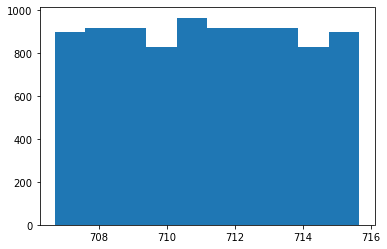

In [9]:
plt.hist(r)

In [10]:
np.max(r)

715.655818113707

(array([ 586., 1000., 1000., 1000.,  988., 1000.,  908., 1000.,  954.,
         586.]),
 array([6.26057747, 6.30881803, 6.3570586 , 6.40529916, 6.45353973,
        6.50178029, 6.55002086, 6.59826143, 6.64650199, 6.69474256,
        6.74298312]),
 <BarContainer object of 10 artists>)

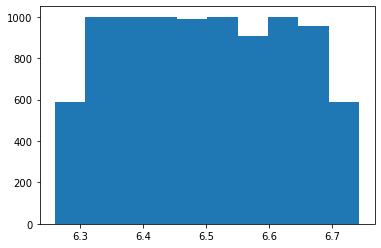

In [11]:
plt.hist(th)

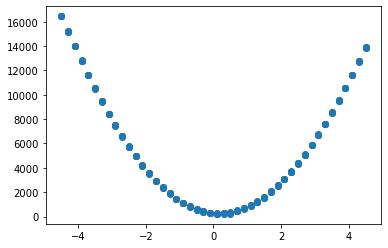

In [12]:
cut=np.where(np.abs(r-711)<0.1)
plt.scatter(z[cut],V[cut])

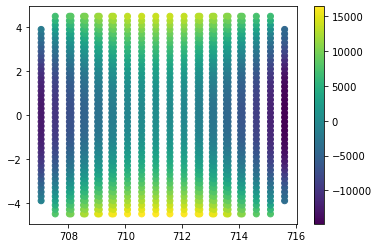

In [13]:
cut=np.where(np.abs(th-6.5)<0.03)
plt.scatter(r[cut],z[cut], c=V[cut])
plt.colorbar()

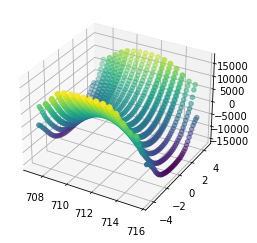

In [21]:
ax = plt.axes(projection='3d')
ax.scatter(r[cut],z[cut],V[cut], c=V[cut], cmap='viridis')

###  <font color='red'>  Project work \#2: </font>  

Time to do some plotting and examine the interesting aspects of the data.  

Lets look at the potential V and how it is changing between the plates.  
Plot V versus the radius r and versus the vertical z.

When you do that, you may notice the plots don't look very clean.  
Try to think what may be going on.

### Data cuts

The data here covers a big volume. We won't be able to get a clean view of everything if we plot everything together.  
For example, if we want to look at how the potential is changing radially, we should focus only very close to z=0. The radial variation of the potential for bigger values of z looks very different. We may also want to choose a narrow angle range also.

This powerful technique of selecting only the data of interest, is called applying a "cut". Here is an example of how data cuts work:

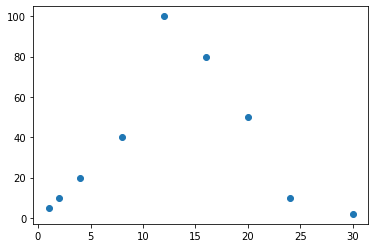

In [23]:
import numpy as np
## Here are two arrays of data:
x1=np.array([5,10,20,40,100,80,50,10, 2])
x2=np.array([1, 2, 4, 8, 12,16,20,24,30])

## Lets plot them:
plt.scatter(x2,x1)

It looks like the behavior of the data is changing around x2=12.  
Lets cut the data for x2<=12, and then for x2>=12. Then we can examine these regions separately:

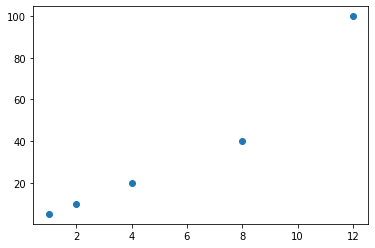

In [24]:
## Define the cut for x2<=12
cut=np.where(x2<=12)

## Lets plot just the x2<=12 region:
plt.scatter(x2[cut],x1[cut])

Now lets do the same for the x>=12 region:

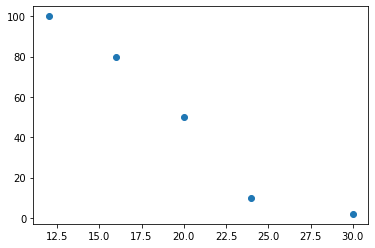

In [25]:
## Define the cut for x2>=12
cut=np.where(x2>=12)

## Lets plot just the x2>=12 region:
plt.scatter(x2[cut],x1[cut])

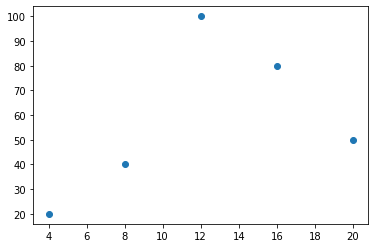

In [27]:
## To combine two cuts, use '&'.
## eg, to look at the central c2 region:
cut=np.where((x2<=20) & (x2>=4) )
plt.scatter(x2[cut],x1[cut])

With the powerful technique of cutting, now try to plot cleaner pictures of the potential along the radial and vertical directions.

Interesting plots to produce:
* V vs r (try cutting near the vertical center)
* V vs z (try cutting near the radial center)
* Colored 2D and 3D plots of the potential V on the r-z plane (try cutting on a thin angular slice)

Feel free also to take a look at the E-field projections. The force experienced by a stored muon will be along the direction of the total E-field.

It is incredibly powerful to be able to produce meaningful plots. You've dug deep into the data, and you are conveying the truth of a dataset with a beautiful plot. People will appreciate you for it and think you've done great work.  


You should start putting together a presentation with the plots you're creating. If you'd like, try adding titles to the plots and axes -- they are also an important part of producing a meaningful plot that communicates information.

## Fitting data to a model function

And now, a small detour to introduce data fitting. 

By fitting data to a model function, we get to describe the data in a much more simplified and predictive way.  
Rather than having to look at 1000's of data points and examine their behavior by-eye on plots, instead we can describe and predict everything with just a handful of parameters. 

One of the simplest functions we can define is just a line. It has two parameters, an intercept and a slope.  
Here is how we define it in python:

In [1]:
## function that returns a line
def line(x,pars):
    intercept=pars[0]
    slope=pars[1]
    result = intercept + slope*x
    return result

Now we can use that function to find any point on a line for any value of x, given some line parameters.
Eg, a line with intercept=0 and slope=1 is just the y=x line.  
Indeed for these values, our function  returns y=x:

In [77]:
intercept=0
slope=1
## package the parameters into the "pars" list, which is passed to the function
pars=[intercept,slope]

## Print the result for a few values of x
xvalues=[0,1,3,5.5,10.8,20]
for x in xvalues:
    y=line(x,pars)
    print ('For x=%.1f, y=%.1f' % (x,y) )

For x=0.0, y=0.0
For x=1.0, y=1.0
For x=3.0, y=3.0
For x=5.5, y=5.5
For x=10.8, y=10.8
For x=20.0, y=20.0


In fact having the function for the line, we can plot it very easily:

In [35]:
import matplotlib.pyplot as plt

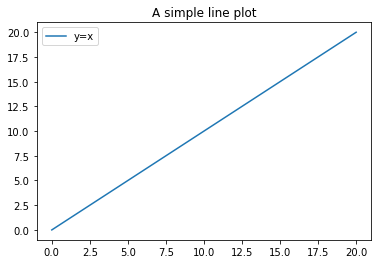

In [79]:
xvalues=np.array(xvalues)
yvalues=line(xvalues,pars)

plt.plot(xvalues,yvalues, label='y=x')
plt.title('A simple line plot')
plt.legend()

And from there we can define any function we want, eg a 2nd-degree polynomial, or any function of arbitrary complexity.

In [64]:
## function that returns the 2nd-degree polynomial
def pol2(x,p0,p1,p2):
    result = p0 + p1*x + p2*x**2
    return result

In [66]:
## parameters for the y=x^2 function
p0,p1,p2 = 0,0,1

## this just prints the value of y=x^2 at x=2
pol2(2,p0,p1,p2)

4

Now for the fitting part.

Rather than plugging in arbitrary parameters by hand, we can try to find the "truth" of a dataset, the parameter values that best describe it, given a model function.  
This procedure is called fitting.

For example, lets take two test arrays we saw before, but only the first region:

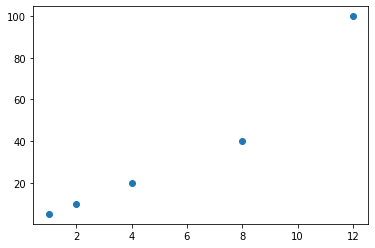

In [49]:
## Here are two arrays of data:
x1=np.array([5,10,20,40,100])
x2=np.array([1, 2, 4, 8, 12])

## Lets plot them:
plt.scatter(x2,x1)

In [50]:
from scipy.optimize import curve_fit

In [82]:
initial_guess=[0,0,5]
params, params_cov = curve_fit(pol2, x2, x1,p0=initial_guess)

In [83]:
params

array([ 8.71525796, -1.42412771,  0.74181292])

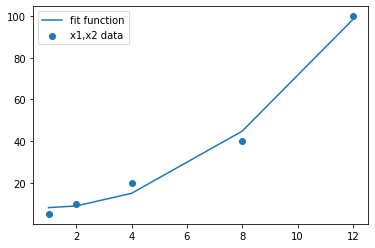

In [84]:
plt.scatter(x2,x1, label='x1,x2 data')
plt.plot(x2,pol2(x2,*params), label='fit function')
plt.legend()

That's a pretty good fit, given that the x1,x2 vectors were randomly created, and I thought a 2nd degree polynomial is reasonably good enough to describe the dataset!  


Notice that now we have described the entire relationship between x1,x2, at least in the region we are examining.  
So now for any arbitrary value x2, we can give a very good prediction what value x1 corresponds to it. For example for x2=6:

In [85]:
## value of x1 that corresponds to x2=6:
x1_at6 = pol2(6,*params)
print(x1_at6)

26.875756774102015


You can verify from the plot that this is a very good prediction.

###  <font color='red'>  Project work \#3: </font>  

We learned a lot about fitting, now lets put it to use:
* Get the data of the potential versus vertical location. 
* Fit V vs z with a 2nd-degree polynomial. 
* Plot the V:z data and fitted function, make sure we get a good fit.